In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from numpy import array, newaxis
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from random import sample
import random
from numpy.random import uniform
from math import isnan
from tslearn.clustering import KShape, TimeSeriesKMeans
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import pickle
import joblib
from scipy.special import boxcox, inv_boxcox
import seaborn as sns
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, Input, Concatenate, Reshape, Lambda, Flatten
from keras.layers import BatchNormalization
from keras import backend as K
from keras.utils.vis_utils import plot_model

2023-07-07 12:54:02.339588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 12:54:02.400698: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-07 12:54:02.417942: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-07 12:54:02.692492: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

##### Data Set Information: 
Data set has no missing values.
Values are in kW of each 15 min. To convert values in kWh values must be divided by 4.
Each column represent one client. Some clients were created after 2011. In these cases consumption were considered zero.
All time labels report to Portuguese hour. However all days present 96 measures (24*4). Every year in March time change day (which has only 23 hours) the values between 1:00 am and 2:00 am are zero for all points. Every year in October time change day (which has 25 hours) the values between 1:00 am and 2:00 am aggregate the consumption of two hours.

In [2]:
# raw_dataset = pd.read_csv('UCI electricity data/LD2011_2014.txt', header=0, sep=';', index_col=0, decimal=",")

### Values are in kW of each 15 min. To convert values in kWh values must be divided by 4. 

In [3]:
# kwh_dataset = raw_dataset / 4

In [4]:
# kwh_dataset.describe().iloc[1].mean()

### Stack house columns

In [5]:
# kwh_dataset_stacked = kwh_dataset.stack().reset_index()

In [6]:
# kwh_dataset_stacked.rename(columns={'level_0': 'Timestamp', 'level_1': 'houseID', 0: 'Energy(kWh)'}, inplace=True)

In [7]:
# kwh_dataset_stacked.sort_values('houseID', inplace=True)

In [8]:
# kwh_dataset_stacked.set_index('Timestamp', inplace=True)

### Datetime engineering

In [9]:
# kwh_dataset_stacked.index = pd.to_datetime(kwh_dataset_stacked.index)

In [10]:
# kwh_dataset_stacked['Month'] = kwh_dataset_stacked.index.month
# kwh_dataset_stacked['Hour'] = kwh_dataset_stacked.index.hour
# kwh_dataset_stacked['Minute'] = kwh_dataset_stacked.index.minute
# kwh_dataset_stacked['DayOfYear'] = kwh_dataset_stacked.index.strftime('%j').astype(int)
# kwh_dataset_stacked['Date'] = kwh_dataset_stacked.index.date
# kwh_dataset_stacked['Year'] = kwh_dataset_stacked.index.year
# # Weekday as a number 0-6, 0 is Sunday
# kwh_dataset_stacked['Weekday'] = kwh_dataset_stacked.index.strftime('%w').astype(int)

### 15 min to 60 min

In [11]:
# kwh_hourly_dataset_stacked = kwh_dataset_stacked.groupby(['houseID', 'Year', 'Month', 'DayOfYear', 'Date', 'Weekday', 'Hour']).sum().reset_index().drop('Minute', 1)

In [12]:
# kwh_hourly_dataset_stacked.to_csv('kwh_hourly_dataset_stacked.csv')

In [13]:
kwh_hourly_dataset_stacked = pd.read_csv('kwh_hourly_dataset_stacked.csv')

In [15]:
kwh_hourly_dataset_stacked.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,Year,Month,DayOfYear,Weekday,Hour,Energy(kWh)
count,12974050.00000,12974050.00000,12974050.00000,12974050.00000,12974050.00000,12974050.00000
mean,2012.49973,6.52277,183.12006,2.99798,11.49967,528.51720
std,1.11779,3.44878,105.44163,2.00049,6.92236,3211.97339
min,2011.00000,1.00000,1.00000,0.00000,0.00000,0.00000
25%,2012.00000,4.00000,92.00000,1.00000,5.00000,20.42598
50%,2012.00000,7.00000,183.00000,3.00000,11.00000,99.71822
75%,2013.00000,10.00000,274.00000,5.00000,17.00000,277.06693
max,2015.00000,12.00000,366.00000,6.00000,23.00000,191000.00000


### Remove outliers

In [16]:
kwh_hourly_dataset_stacked['Zscore'] = np.abs(stats.zscore(kwh_hourly_dataset_stacked['Energy(kWh)']))
kwh_hourly_dataset_stacked = kwh_hourly_dataset_stacked.loc[kwh_hourly_dataset_stacked['Zscore'] < 3]

In [17]:
kwh_hourly_dataset_stacked.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,Year,Month,DayOfYear,Weekday,Hour,Energy(kWh),Zscore
count,12871466.00000,12871466.00000,12871466.00000,12871466.00000,12871466.00000,12871466.00000,12871466.00000
mean,2012.49781,6.52242,183.10956,2.99779,11.49252,323.98998,0.15896
std,1.11798,3.44940,105.46130,2.00055,6.92468,772.45158,0.19137
min,2011.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000
25%,2011.00000,4.00000,92.00000,1.00000,5.00000,19.79346,0.10873
50%,2012.00000,7.00000,183.00000,3.00000,11.00000,98.32470,0.14203
75%,2013.00000,10.00000,274.00000,5.00000,17.00000,268.62170,0.16455
max,2015.00000,12.00000,366.00000,6.00000,23.00000,10163.86555,2.99982


### Remove houseIDs that have limited data (MT_362)

/tmp/ipykernel_2402268/4040791369.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Hour", y='Energy(kWh)', data=kwh_hourly_dataset_stacked.loc[kwh_hourly_dataset_stacked['houseID']=='MT_362'], palette="Blues_d", ax = ax, ci=None)


<AxesSubplot: xlabel='Hour', ylabel='Energy(kWh)'>

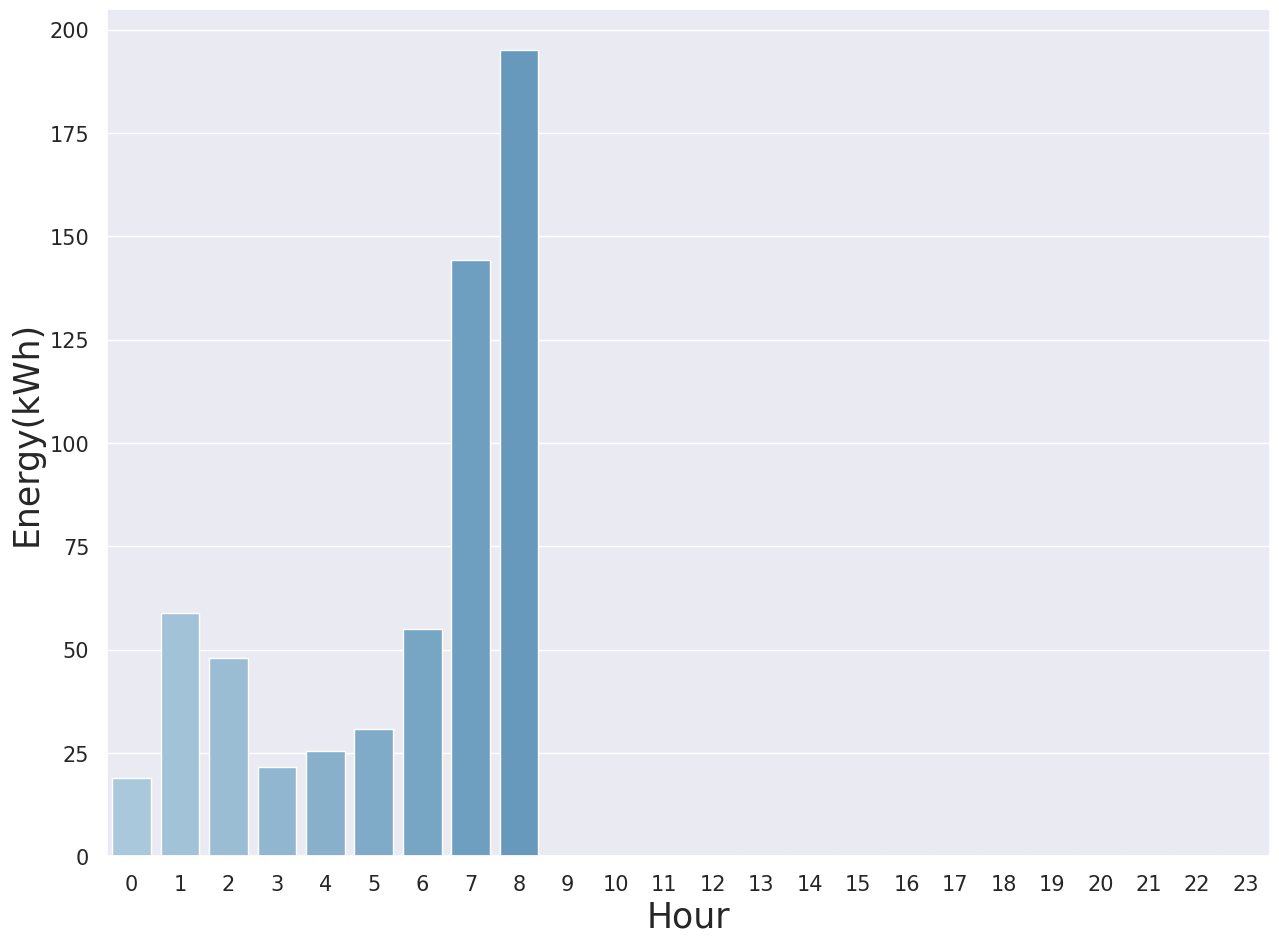

In [21]:
sns.set()
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,11]

plt.rcParams["font.size"] = "20"
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)


ax = plt.axes()
# ax.set_title('Mean energy by hour', fontsize=30)
ax.set_ylabel("Energy(kWh)", fontsize=25)
ax.set_xlabel("Hour", fontsize=25)

sns.barplot(x="Hour", y='Energy(kWh)', data=kwh_hourly_dataset_stacked.loc[kwh_hourly_dataset_stacked['houseID']=='MT_362'], palette="Blues_d", ax = ax, ci=None)

In [22]:
kwh_hourly_dataset_stacked = kwh_hourly_dataset_stacked.loc[kwh_hourly_dataset_stacked['houseID'] != 'MT_362']

/tmp/ipykernel_2391835/3199833325.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Hour", y='Energy(kWh)', data=kwh_hourly_dataset_stacked, palette="Blues_d", ax = ax, ci=None)


<AxesSubplot: xlabel='Hour', ylabel='Energy(kWh)'>

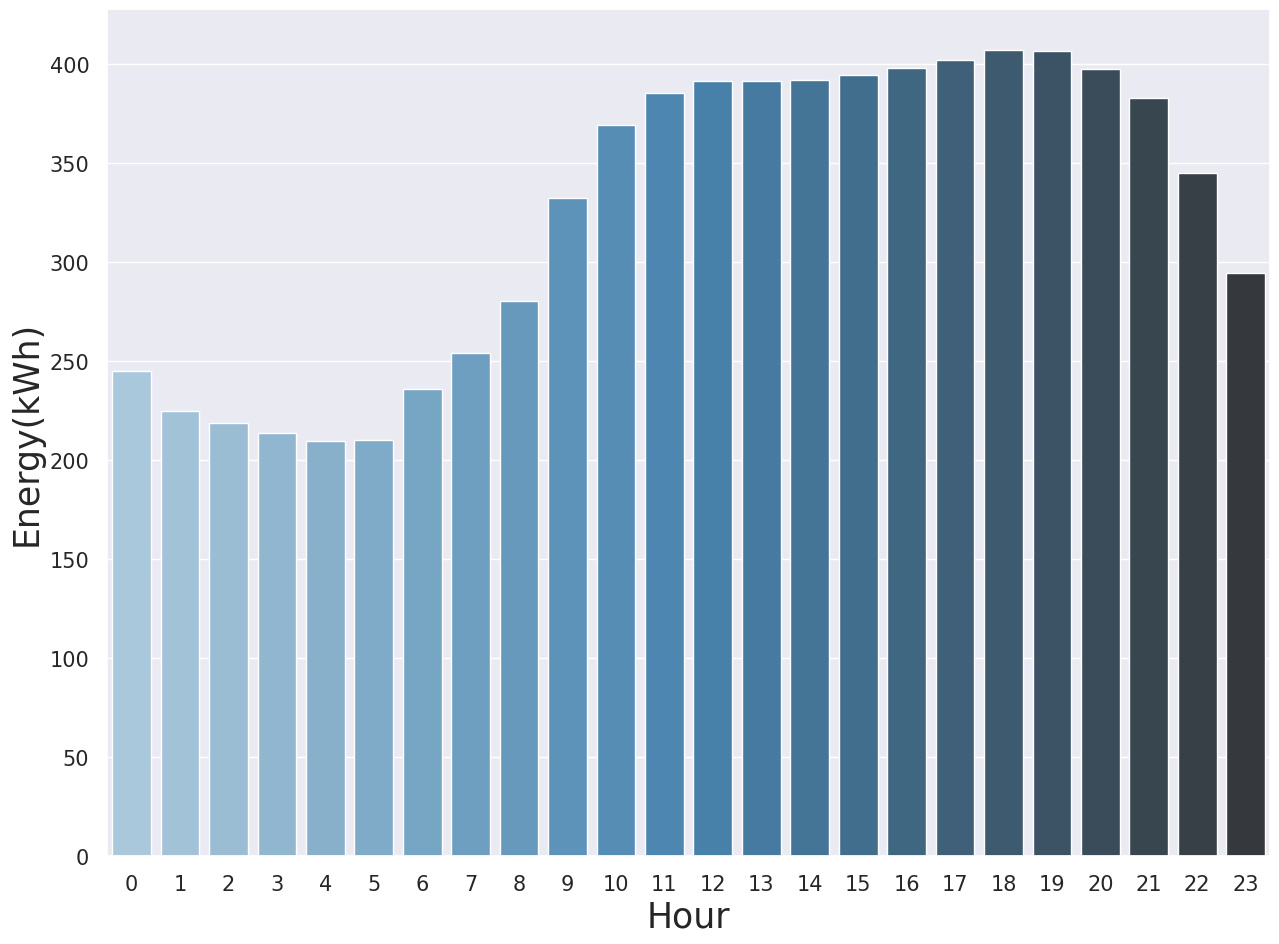

In [22]:
sns.set()
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,11]

plt.rcParams["font.size"] = "20"
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)


ax = plt.axes()
# ax.set_title('Mean energy by hour', fontsize=30)
ax.set_ylabel("Energy(kWh)", fontsize=25)
ax.set_xlabel("Hour", fontsize=25)

sns.barplot(x="Hour", y='Energy(kWh)', data=kwh_hourly_dataset_stacked, palette="Blues_d", ax = ax, ci=None)

/tmp/ipykernel_2391835/2508249796.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x="Hour", y='Energy(kWh)', data=kwh_hourly_dataset_stacked, palette="Blues_d", ax = ax, ci='sd')


<AxesSubplot: xlabel='Hour', ylabel='Energy(kWh)'>

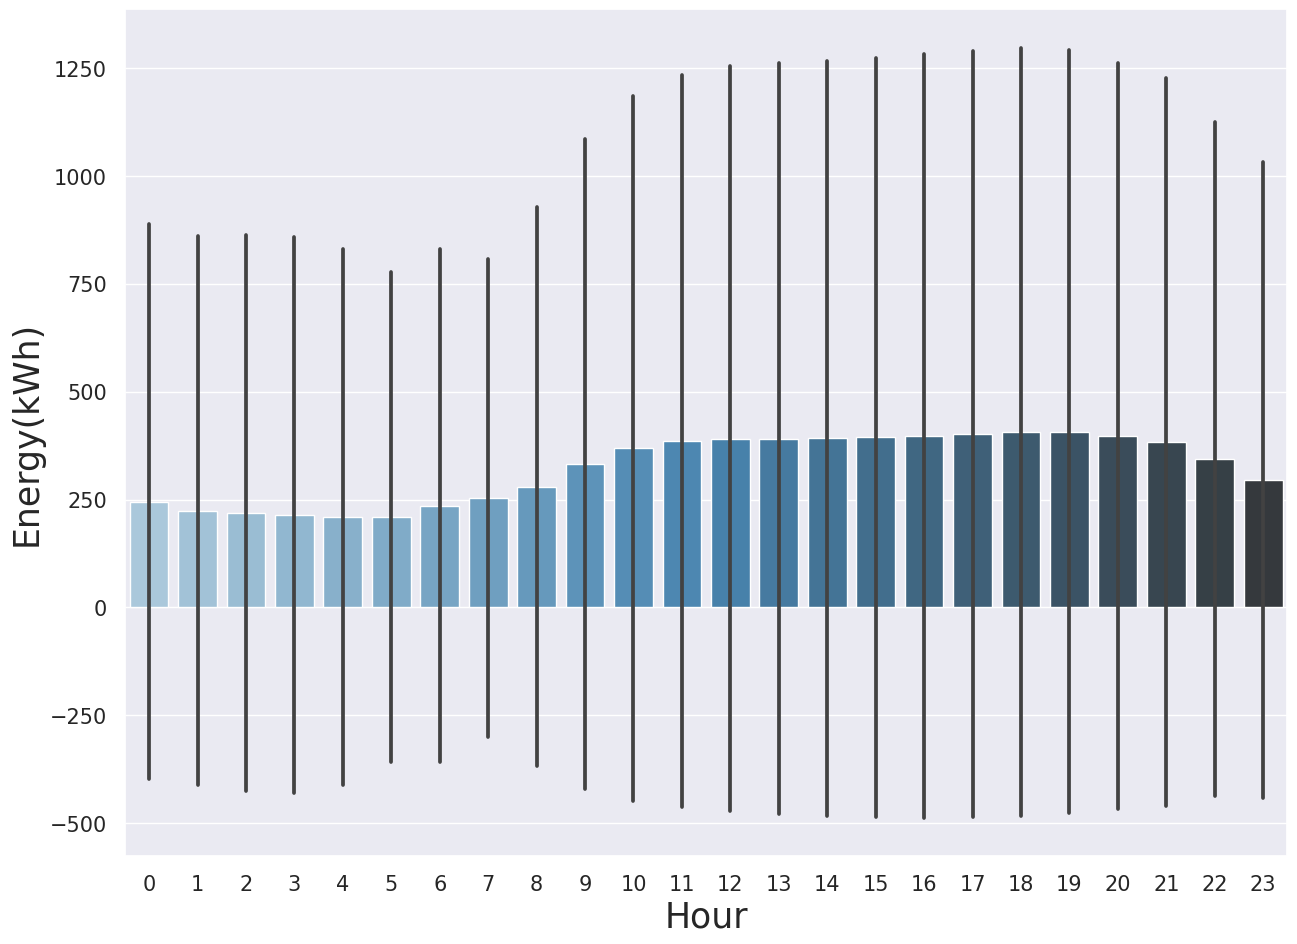

In [23]:
sns.set()
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,11]

plt.rcParams["font.size"] = "20"
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)


ax = plt.axes()
# ax.set_title('Mean energy by hour', fontsize=30)
ax.set_ylabel("Energy(kWh)", fontsize=25)
ax.set_xlabel("Hour", fontsize=25)

sns.barplot(x="Hour", y='Energy(kWh)', data=kwh_hourly_dataset_stacked, palette="Blues_d", ax = ax, ci='sd')

<AxesSubplot: xlabel='Hour', ylabel='Energy(kWh)'>

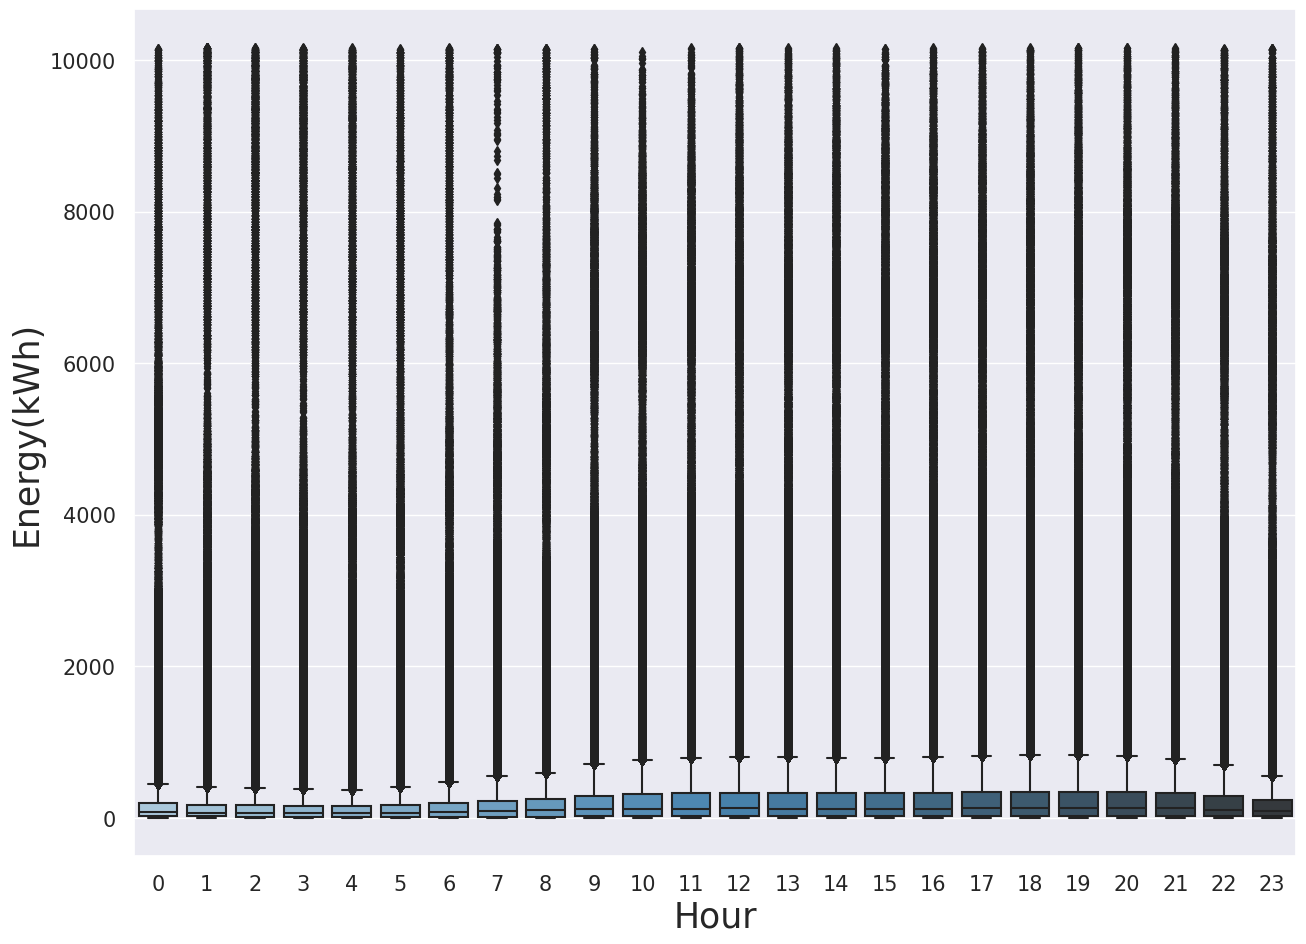

In [24]:
sns.set()
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,11]

plt.rcParams["font.size"] = "20"
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)


ax = plt.axes()
# ax.set_title('Mean energy by hour', fontsize=30)
ax.set_ylabel("Energy(kWh)", fontsize=25)
ax.set_xlabel("Hour", fontsize=25)

sns.boxplot(x="Hour", y='Energy(kWh)', data=kwh_hourly_dataset_stacked, palette="Blues_d", ax = ax)

### Consumer profile features

#### Consumption figures (aggregates of consumption during different periods, e.g. daily, 6:00-9:00, weekends etc.) 

#### Calculate average, min, max consumption per house

In [25]:
use_per_house = kwh_hourly_dataset_stacked.groupby(['houseID'], axis=0)['Energy(kWh)'].agg(['min', 'max', 'mean', 'var', 'std'])

In [26]:
use_per_house_weekdays = kwh_hourly_dataset_stacked.loc[kwh_hourly_dataset_stacked['Weekday'].isin([2,3,4,5])].groupby(['houseID'], axis=0)['Energy(kWh)'].agg(['min', 'max', 'mean'])

In [27]:
use_per_house_weekends = kwh_hourly_dataset_stacked.loc[kwh_hourly_dataset_stacked['Weekday'].isin([1,6])].groupby(['houseID'], axis=0)['Energy(kWh)'].agg(['min', 'max', 'mean'])

#### Calculate average consumption per house and per hour (daily profiles)

In [28]:
use_per_house_per_hour = kwh_hourly_dataset_stacked.groupby(['houseID','Hour'], axis=0)['Energy(kWh)'].mean()

In [29]:
use_per_house_per_hour = pd.DataFrame(use_per_house_per_hour).reset_index()

#### Normalize consumption with house mean

In [30]:
def normalize_row_avg(row):
    dataid = row['houseID']
    return row['Energy(kWh)']/use_per_house.loc[dataid]['mean']

In [31]:
use_per_house_per_hour['normalized_use_mean'] = use_per_house_per_hour.apply(lambda row: normalize_row_avg(row), axis=1)

#### Pivot the table so that there are 24 features/columns for each house (and drop rows with NaN)

In [32]:
load_profiles = pd.DataFrame(use_per_house_per_hour).reset_index().pivot(index='houseID',columns='Hour',values='normalized_use_mean').dropna()

In [33]:
load_profiles.head(3)

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
houseID,,,,,,,,,,,,,,,,,,,,,
MT_001,0.907270,0.941580,0.920470,0.930751,0.937478,0.932994,0.890446,0.865179,1.036301,1.433069,...,1.056481,1.003542,0.902149,1.003980,1.025691,0.968432,0.958752,1.040676,1.045981,1.012730
MT_002,0.893590,0.802073,0.761070,0.753047,0.761386,0.792468,0.900032,1.125017,1.164298,1.134774,...,1.043490,0.985990,0.967729,0.993403,1.073500,1.176651,1.208109,1.106247,0.979420,0.929878
MT_003,1.076328,1.196275,1.376516,1.431230,1.351196,1.397505,1.275034,1.080427,0.858055,0.802220,...,0.771959,0.884903,0.936357,1.010939,0.978742,0.885056,0.939974,1.028260,1.060610,0.991020


#### Total consumption per day for each household

In [34]:
daily_consumption = kwh_hourly_dataset_stacked.groupby(['houseID', 'Date', 'Weekday', 'Month', 'DayOfYear', 'Year'], axis=0)['Energy(kWh)'].sum().reset_index()

#### Average for each household

In [35]:
daily_consumption_avg = daily_consumption.groupby(['houseID'], axis=0)['Energy(kWh)'].mean().reset_index()

In [36]:
daily_consumption_avg.rename(columns={'Energy(kWh)': 'Total Daily Energy Mean(kWh)'}, inplace=True)

#### Weekday average for each household

In [37]:
daily_consumption_avg_weekday = daily_consumption.loc[daily_consumption['Weekday'].isin([2,3,4,5])].groupby(['houseID'], axis=0)['Energy(kWh)'].mean().reset_index()

#### Weekend average for each household

In [38]:
daily_consumption_avg_weekend = daily_consumption.loc[daily_consumption['Weekday'].isin([1,6])].groupby(['houseID'], axis=0)['Energy(kWh)'].mean().reset_index()

#### Average daily consumption per month for each household

In [39]:
daily_consumption_avg_month = daily_consumption.groupby(['houseID','Month'], axis=0)['Energy(kWh)'].mean().reset_index()

In [40]:
daily_consumption_avg_month.rename(columns={'Energy(kWh)': 'Total Daily Energy Mean per Month(kWh)'}, inplace=True)

#### Max consumption per day for each household

In [41]:
daily_consumption_max = kwh_hourly_dataset_stacked.groupby(['houseID', 'Date', 'Month', 'DayOfYear', 'Year'], axis=0)['Energy(kWh)'].max().reset_index()

#### Min consumption per day for each household

In [42]:
daily_consumption_min = kwh_hourly_dataset_stacked.groupby(['houseID', 'Date', 'Month', 'DayOfYear', 'Year'], axis=0)['Energy(kWh)'].min().reset_index()

#### Mean consumption per day for each household

In [43]:
daily_consumption_mean = kwh_hourly_dataset_stacked.groupby(['houseID', 'Date', 'Month', 'DayOfYear', 'Year'], axis=0)['Energy(kWh)'].mean().reset_index()

### Consumption ratios (features calculated as the ratio of two consumption figures, e.g. average consumption during afternoon and evening can indicate when cooking is happening) 

In [44]:
use_per_house['mean_over_max'] = use_per_house['mean'] / use_per_house['max'] 

In [45]:
use_per_house['min_over_mean'] = use_per_house['min'] / use_per_house['mean'] 

### Time period features from HABEN et al.: ANALYSIS AND CLUSTERING OF RESIDENTIAL CUSTOMERS ENERGY BEHAVIORAL DEMAND 

#### Time Period 1 - Overnight - 22:00-6:00

In [46]:
# Mean
p_1 = kwh_hourly_dataset_stacked.loc[(kwh_hourly_dataset_stacked['Hour'] >= 22) | (kwh_hourly_dataset_stacked['Hour'] < 6)].groupby(['houseID'], axis=0)['Energy(kWh)'].agg(['mean', 'std'])

In [47]:
# Summer mean
ps_1 = kwh_hourly_dataset_stacked.loc[(kwh_hourly_dataset_stacked['Month'].isin([6,7,8])) & ((kwh_hourly_dataset_stacked['Hour'] >= 22) | (kwh_hourly_dataset_stacked['Hour'] < 6))].groupby(['houseID'], axis=0)['Energy(kWh)'].mean()

In [48]:
# Winter mean
pw_1 = kwh_hourly_dataset_stacked.loc[(kwh_hourly_dataset_stacked['Month'].isin([12,1,2])) & ((kwh_hourly_dataset_stacked['Hour'] >= 22) | (kwh_hourly_dataset_stacked['Hour'] < 6))].groupby(['houseID'], axis=0)['Energy(kWh)'].mean()

In [49]:
# Weekday mean
pwd_1 = kwh_hourly_dataset_stacked.loc[(kwh_hourly_dataset_stacked['Weekday'].isin([2,3,4,5])) & ((kwh_hourly_dataset_stacked['Hour'] >= 22) | (kwh_hourly_dataset_stacked['Hour'] < 6))].groupby(['houseID'], axis=0)['Energy(kWh)'].mean()

In [50]:
# Weekend mean
pwe_1 = kwh_hourly_dataset_stacked.loc[(kwh_hourly_dataset_stacked['Weekday'].isin([1,6])) & ((kwh_hourly_dataset_stacked['Hour'] >= 22) | (kwh_hourly_dataset_stacked['Hour'] < 6))].groupby(['houseID'], axis=0)['Energy(kWh)'].mean()

In [51]:
# Relative average consumption
pr_1 = pd.DataFrame(p_1['mean'] / use_per_house['mean'])
pr_1.rename(columns={'mean': 'Relative average consumption 1'}, inplace=True)

#### Time Period 2 - Breakfast - 6:00-9:00

In [52]:
# Mean
p_2 = kwh_hourly_dataset_stacked.loc[(kwh_hourly_dataset_stacked['Hour'] >= 6) & (kwh_hourly_dataset_stacked['Hour'] < 9)].groupby(['houseID'], axis=0)['Energy(kWh)'].agg(['mean', 'std'])

# Summer mean
ps_2 = kwh_hourly_dataset_stacked.loc[(kwh_hourly_dataset_stacked['Month'].isin([6,7,8])) & ((kwh_hourly_dataset_stacked['Hour'] >= 6) & (kwh_hourly_dataset_stacked['Hour'] < 9))].groupby(['houseID'], axis=0)['Energy(kWh)'].mean()

# Winter mean
pw_2 = kwh_hourly_dataset_stacked.loc[(kwh_hourly_dataset_stacked['Month'].isin([12,1,2])) & ((kwh_hourly_dataset_stacked['Hour'] >= 6) & (kwh_hourly_dataset_stacked['Hour'] < 9))].groupby(['houseID'], axis=0)['Energy(kWh)'].mean()

# Weekday mean
pwd_2 = kwh_hourly_dataset_stacked.loc[(kwh_hourly_dataset_stacked['Weekday'].isin([2,3,4,5])) & ((kwh_hourly_dataset_stacked['Hour'] >= 6) & (kwh_hourly_dataset_stacked['Hour'] < 9))].groupby(['houseID'], axis=0)['Energy(kWh)'].mean()

# Weekend mean
pwe_2 = kwh_hourly_dataset_stacked.loc[(kwh_hourly_dataset_stacked['Weekday'].isin([1,6])) & ((kwh_hourly_dataset_stacked['Hour'] >= 6) & (kwh_hourly_dataset_stacked['Hour'] < 9))].groupby(['houseID'], axis=0)['Energy(kWh)'].mean()

# Relative average consumption
pr_2 = pd.DataFrame(p_2['mean'] / use_per_house['mean'])
pr_2.rename(columns={'mean': 'Relative average consumption 2'}, inplace=True)

#### Time Period 3 - Daytime - 9:00-15:00

In [53]:
# Mean
p_3 = kwh_hourly_dataset_stacked.loc[(kwh_hourly_dataset_stacked['Hour'] >= 9) & (kwh_hourly_dataset_stacked['Hour'] < 15)].groupby(['houseID'], axis=0)['Energy(kWh)'].agg(['mean', 'std'])

# Summer mean
ps_3 = kwh_hourly_dataset_stacked.loc[(kwh_hourly_dataset_stacked['Month'].isin([6,7,8])) & ((kwh_hourly_dataset_stacked['Hour'] >= 9) & (kwh_hourly_dataset_stacked['Hour'] < 15))].groupby(['houseID'], axis=0)['Energy(kWh)'].mean()

# Winter mean
pw_3 = kwh_hourly_dataset_stacked.loc[(kwh_hourly_dataset_stacked['Month'].isin([12,1,2])) & ((kwh_hourly_dataset_stacked['Hour'] >= 9) & (kwh_hourly_dataset_stacked['Hour'] < 15))].groupby(['houseID'], axis=0)['Energy(kWh)'].mean()

# Weekday mean
pwd_3 = kwh_hourly_dataset_stacked.loc[(kwh_hourly_dataset_stacked['Weekday'].isin([2,3,4,5])) & ((kwh_hourly_dataset_stacked['Hour'] >= 9) & (kwh_hourly_dataset_stacked['Hour'] < 15))].groupby(['houseID'], axis=0)['Energy(kWh)'].mean()

# Weekend mean
pwe_3 = kwh_hourly_dataset_stacked.loc[(kwh_hourly_dataset_stacked['Weekday'].isin([1,6])) & ((kwh_hourly_dataset_stacked['Hour'] >= 9) & (kwh_hourly_dataset_stacked['Hour'] < 15))].groupby(['houseID'], axis=0)['Energy(kWh)'].mean()

# Relative average consumption
pr_3 = pd.DataFrame(p_3['mean'] / use_per_house['mean'])
pr_3.rename(columns={'mean': 'Relative average consumption 3'}, inplace=True)

#### Time Period 4 - Evening - 15:00-22:00

In [54]:
# Mean
p_4 = kwh_hourly_dataset_stacked.loc[(kwh_hourly_dataset_stacked['Hour'] >= 15) & (kwh_hourly_dataset_stacked['Hour'] < 22)].groupby(['houseID'], axis=0)['Energy(kWh)'].agg(['mean', 'std'])

# Summer mean
ps_4 = kwh_hourly_dataset_stacked.loc[(kwh_hourly_dataset_stacked['Month'].isin([6,7,8])) & ((kwh_hourly_dataset_stacked['Hour'] >= 15) & (kwh_hourly_dataset_stacked['Hour'] < 22))].groupby(['houseID'], axis=0)['Energy(kWh)'].mean()

# Winter mean
pw_4 = kwh_hourly_dataset_stacked.loc[(kwh_hourly_dataset_stacked['Month'].isin([12,1,2])) & ((kwh_hourly_dataset_stacked['Hour'] >= 15) & (kwh_hourly_dataset_stacked['Hour'] < 22))].groupby(['houseID'], axis=0)['Energy(kWh)'].mean()

# Weekday mean
pwd_4 = kwh_hourly_dataset_stacked.loc[(kwh_hourly_dataset_stacked['Weekday'].isin([2,3,4,5])) & ((kwh_hourly_dataset_stacked['Hour'] >= 15) & (kwh_hourly_dataset_stacked['Hour'] < 22))].groupby(['houseID'], axis=0)['Energy(kWh)'].mean()

# Weekend mean
pwe_4 = kwh_hourly_dataset_stacked.loc[(kwh_hourly_dataset_stacked['Weekday'].isin([1,6])) & ((kwh_hourly_dataset_stacked['Hour'] >= 15) & (kwh_hourly_dataset_stacked['Hour'] < 22))].groupby(['houseID'], axis=0)['Energy(kWh)'].mean()

# Relative average consumption
pr_4 = pd.DataFrame(p_4['mean'] / use_per_house['mean'])
pr_4.rename(columns={'mean': 'Relative average consumption 4'}, inplace=True)

#### Mean relative standard deviation

In [55]:
mean_relative_std = pd.DataFrame(pd.Series((1/4) * sum([p_1['std']/p_1['mean'], p_2['std']/p_2['mean'], p_3['std']/p_3['mean'], p_4['std']/p_4['mean']]), name='mean'))
mean_relative_std.rename(columns={'mean': 'Mean relative standard deviation'}, inplace=True)

#### Seasonal score

In [56]:
seasonal_score = pd.DataFrame(pd.Series(sum([abs(pw_1 - ps_1)/p_1['mean'], abs(pw_2 - ps_2)/p_2['mean'], abs(pw_3 - ps_3)/p_3['mean'], abs(pw_4 - ps_4)/p_4['mean']]), name='mean'))
seasonal_score.rename(columns={'mean': 'Seasonal score'}, inplace=True)

#### Weekend vs weekday difference score

In [57]:
weekend_weekday_difference_score = pd.DataFrame(pd.Series(sum([abs(pwd_1 - pwe_1)/p_1['mean'], abs(pwd_2 - pwe_2)/p_2['mean'], abs(pwd_3 - pwe_3)/p_3['mean'], abs(pwd_4 - pwe_4)/p_4['mean']]), name='mean'))
weekend_weekday_difference_score.rename(columns={'mean': 'Weekend vs weekday difference score'}, inplace=True)

In [58]:
use_per_house.describe()

,min,max,mean,var,std,mean_over_max,min_over_mean
count,369.000000,369.000000,369.000000,3.690000e+02,369.000000,369.000000,369.000000
mean,0.509047,894.746242,362.643833,1.362279e+05,166.506443,0.352517,0.001881
std,1.557458,1705.176591,888.140617,6.103102e+05,329.845889,0.154162,0.003441
min,0.000000,20.728643,0.818035,4.648295e+00,2.155991,0.018558,0.000000
25%,0.000000,156.976333,41.790646,8.616542e+02,29.353947,0.247189,0.000000
50%,0.000000,292.443409,104.696434,3.127117e+03,55.920630,0.332624,0.000000
75%,0.000000,750.000000,295.903191,1.620670e+04,127.305535,0.493226,0.000000
max,15.243902,10163.865546,9291.823477,7.324786e+06,2706.434185,0.914887,0.019337


In [61]:
clustering_profiles = weekend_weekday_difference_score \
.merge(load_profiles, left_index=True, right_index=True, how='inner') \
.merge(use_per_house['mean_over_max'], left_index=True, right_index=True, how='inner') \
.merge(use_per_house['min_over_mean'], left_index=True, right_index=True, how='inner') \
.merge(use_per_house['var'], left_index=True, right_index=True, how='inner') \
.merge(use_per_house['mean'], left_index=True, right_index=True, how='inner') \
.merge(use_per_house['max'], left_index=True, right_index=True, how='inner') \
.merge(use_per_house['min'], left_index=True, right_index=True, how='inner') \
.merge(pr_1, left_index=True, right_index=True, how='inner') \
.merge(pr_2, left_index=True, right_index=True, how='inner') \
.merge(pr_3, left_index=True, right_index=True, how='inner') \
.merge(pr_4, left_index=True, right_index=True, how='inner') \
.merge(mean_relative_std, left_index=True, right_index=True, how='inner') \
# .merge(seasonal_score, left_index=True, right_index=True, how='inner') \

In [62]:
clustering_profiles = clustering_profiles[~clustering_profiles.isin([np.nan, np.inf, -np.inf]).any(1)]

/tmp/ipykernel_2391835/366663329.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  clustering_profiles = clustering_profiles[~clustering_profiles.isin([np.nan, np.inf, -np.inf]).any(1)]


In [63]:
clustering_profiles.to_csv('clustering_profiles2023.csv')

### Household Clustering

#### Time series clustering

In [64]:
clustering_profiles = load_profiles

In [65]:
clustering_profiles = clustering_profiles[~clustering_profiles.isin([np.nan, np.inf, -np.inf]).any(1)]

/tmp/ipykernel_2391835/366663329.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  clustering_profiles = clustering_profiles[~clustering_profiles.isin([np.nan, np.inf, -np.inf]).any(1)]


In [66]:
X = np.array(clustering_profiles)

In [67]:
X.shape

(369, 24)

In [68]:
X = X.reshape(X.shape[0],X.shape[1], 1)

In [69]:
X.shape

(369, 24, 1)

In [70]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    seed=7
    rand_X = random.Random(seed).sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [71]:
print("Hopkins test H = "+str(hopkins(clustering_profiles)))

Hopkins test H = 0.9130203934499609


#### k-Means with DTW as a distance measure

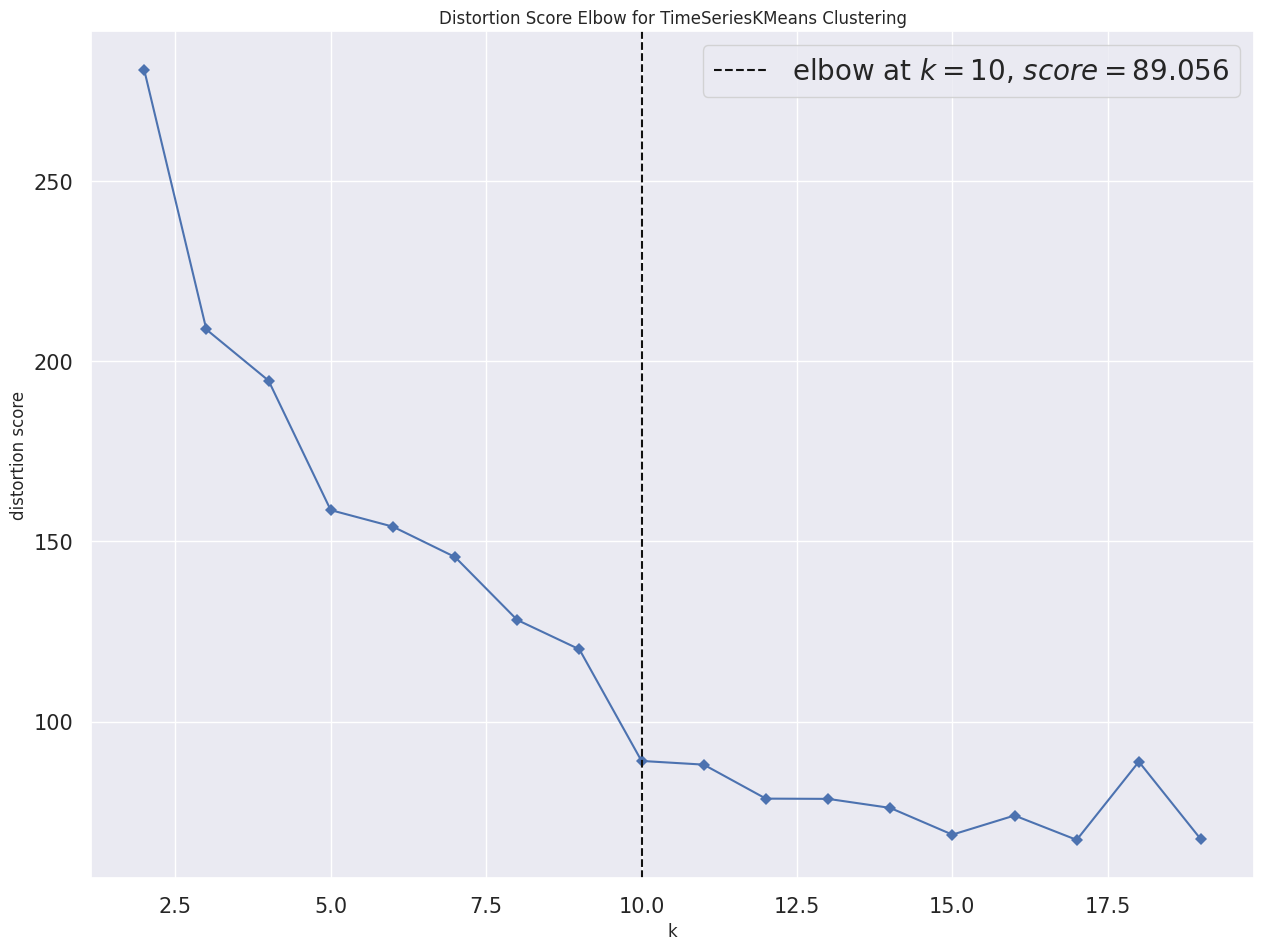

<AxesSubplot: title={'center': 'Distortion Score Elbow for TimeSeriesKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [190]:
# Instantiate the clustering model and visualizer
model = TimeSeriesKMeans(
    
       random_state=7, verbose= 0, metric="softdtw"
    )

visualizer = KElbowVisualizer(model, k=(2,20), timings=False)

visualizer.fit(X.reshape(X.shape[0],X.shape[1]))        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [191]:
visualizer.elbow_value_

10

In [72]:
kmeans = TimeSeriesKMeans(
    # n_clusters=visualizer.elbow_value_, 
    n_clusters=10, 
    random_state=7, verbose= 0, metric="dtw"
    ).fit(X)

In [73]:
# pickle.dump(kmeans, open('uci_timeseries_kmeans2023_10_clusters.pkl', 'wb'))

In [ ]:
# calculate distortion for a range of number of cluster
distortions = []
db_indexes = {}
for i in range(2, 20):
    km = TimeSeriesKMeans(
        n_clusters=i, random_state=7, verbose= 0, metric="softdtw", dtw_inertia=True 
    )
    km.fit(X)
    distortions.append(km.inertia_)
    
    labels = km.labels_
    db_indexes[i] = davies_bouldin_score(X.reshape(X.shape[0],X.shape[1]), labels)


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# plot
plt.plot(range(2, 20), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [ ]:
db_indexes

#### Calculate each user's distance from each cluster center

In [75]:
sqr_cluster_distance = kmeans.transform(X)**2

In [76]:
sqr_cluster_distance.shape

(369, 10)

In [77]:
sqr_cluster_distance_df = pd.DataFrame(sqr_cluster_distance).add_prefix('centroid_distance_from_')

In [78]:
clustering_profiles['Cluster'] = kmeans.predict(X)

In [79]:
clustering_profiles.shape

(369, 25)

In [80]:
clustering_profiles = pd.merge(clustering_profiles.reset_index(), sqr_cluster_distance_df, left_index=True, right_index=True, how='inner')

In [81]:
clustering_profiles.index = clustering_profiles['houseID']

In [82]:
clustering_profiles = clustering_profiles.drop('houseID', 1)

/tmp/ipykernel_2391835/1695393503.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  clustering_profiles = clustering_profiles.drop('houseID', 1)


In [83]:
cluster_profile = clustering_profiles.groupby('Cluster').mean()

In [84]:
cluster_profile

,0,1,2,3,4,5,6,7,8,9,...,centroid_distance_from_0,centroid_distance_from_1,centroid_distance_from_2,centroid_distance_from_3,centroid_distance_from_4,centroid_distance_from_5,centroid_distance_from_6,centroid_distance_from_7,centroid_distance_from_8,centroid_distance_from_9
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.576837,0.562026,0.548372,0.542409,0.538741,0.574887,0.740416,0.947228,1.058984,1.222104,...,0.083566,1.235385,1.278398,9.958233,0.177698,22.990826,0.391212,1.497727,2.395926,1.042248
1,1.010514,0.886563,0.813502,0.763659,0.740938,0.739786,0.720200,0.788316,0.900010,0.960720,...,1.440997,0.114504,3.001097,6.970911,0.874266,27.969341,0.465033,0.655124,0.514101,1.741184
2,0.377058,0.302176,0.282160,0.273569,0.270032,0.285226,0.327862,0.455975,0.551332,0.863603,...,1.292206,3.274552,0.194577,16.672083,2.101727,17.403293,2.490327,5.895886,3.496740,0.643813
3,2.394767,1.651095,1.541260,1.516427,1.568981,1.752783,1.891204,1.175067,0.849860,0.678366,...,9.995248,7.524996,17.571648,0.498588,9.608512,35.220037,9.958439,6.279924,5.270032,15.910538
4,0.659626,0.626421,0.609719,0.599540,0.598654,0.644479,0.797993,0.951050,1.010690,1.153092,...,0.173669,0.755129,1.981810,9.276683,0.070884,25.717629,0.147606,0.863372,1.779388,1.284883
5,0.120238,0.120685,0.122606,0.122010,0.120970,0.121414,0.123727,0.113294,0.422904,1.133819,...,22.431081,27.386021,16.465003,34.817113,25.639983,0.000000,27.185369,33.041942,28.921301,21.587085
6,0.794913,0.688151,0.645145,0.624054,0.621580,0.643389,0.713779,0.813973,0.913227,1.094954,...,0.436812,0.389211,2.314287,9.120274,0.162072,27.469803,0.077635,0.541547,1.118718,1.252560
7,0.973884,0.976451,0.976273,0.968249,0.948585,0.931971,0.933321,0.940799,0.961656,1.000686,...,1.729703,0.694693,6.078340,5.763572,1.075220,33.568836,0.770982,0.125244,1.569264,4.429537
8,1.358539,1.260488,0.976698,0.824524,0.752999,0.704968,0.722953,0.636188,0.736364,0.726444,...,3.742983,0.954955,4.920450,5.018156,2.742202,31.641901,1.744772,1.859701,0.297705,2.097304


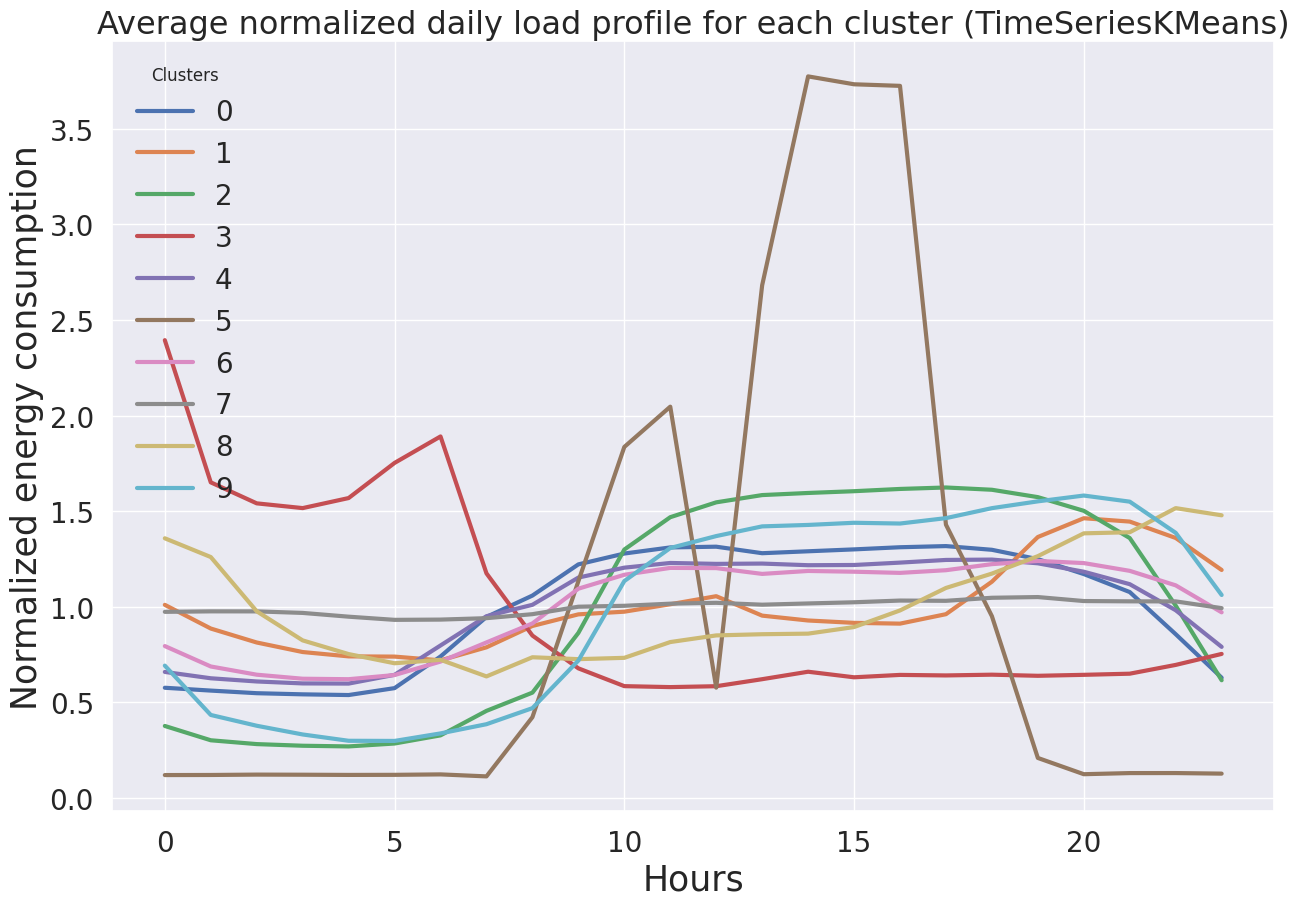

In [85]:
sns.set()

ax = load_profiles.merge(clustering_profiles['Cluster'], left_index=True, right_index=True, how='inner').groupby('Cluster').mean().T.plot(
    figsize=(15,10), linewidth=3, fontsize=20
)

ax.set_title("Average normalized daily load profile for each cluster (TimeSeriesKMeans)", fontsize=23)
ax.set_xlabel("Hours", fontsize=25)
ax.set_ylabel("Normalized energy consumption", fontsize=25)
ax.legend(loc='upper left', fontsize=20, title="Clusters")
plt.rcParams['legend.title_fontsize'] = 'x-large'

In [86]:
clustering_profiles.groupby('Cluster').count()

,0,1,2,3,4,5,6,7,8,9,...,centroid_distance_from_0,centroid_distance_from_1,centroid_distance_from_2,centroid_distance_from_3,centroid_distance_from_4,centroid_distance_from_5,centroid_distance_from_6,centroid_distance_from_7,centroid_distance_from_8,centroid_distance_from_9
Cluster,,,,,,,,,,,,,,,,,,,,,
0,65,65,65,65,65,65,65,65,65,65,...,65,65,65,65,65,65,65,65,65,65
1,64,64,64,64,64,64,64,64,64,64,...,64,64,64,64,64,64,64,64,64,64
2,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
3,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
4,90,90,90,90,90,90,90,90,90,90,...,90,90,90,90,90,90,90,90,90,90
5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,65,65,65,65,65,65,65,65,65,65,...,65,65,65,65,65,65,65,65,65,65
7,35,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
8,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9


In [87]:
clustering_profiles['centroid_distance_from_5'].sort_values()

houseID
MT_093     0.000000
MT_100    12.830623
MT_350    13.909044
MT_343    14.704775
MT_356    14.893729
            ...    
MT_161    37.589089
MT_133    37.640124
MT_149    37.691700
MT_348    38.171165
MT_132    41.027669
Name: centroid_distance_from_5, Length: 369, dtype: float64

In [88]:
clustering_profiles.to_csv('clustering_profiles_timeseries2023.csv')

#### Clustering using the non-timeseries features of the profile

In [89]:
clustering_profiles = weekend_weekday_difference_score \
.merge(use_per_house['mean_over_max'], left_index=True, right_index=True, how='inner') \
.merge(use_per_house['min_over_mean'], left_index=True, right_index=True, how='inner') \
.merge(use_per_house['var'], left_index=True, right_index=True, how='inner') \
.merge(use_per_house['mean'], left_index=True, right_index=True, how='inner') \
.merge(use_per_house['max'], left_index=True, right_index=True, how='inner') \
.merge(use_per_house['min'], left_index=True, right_index=True, how='inner') \
.merge(pr_1, left_index=True, right_index=True, how='inner') \
.merge(pr_2, left_index=True, right_index=True, how='inner') \
.merge(pr_3, left_index=True, right_index=True, how='inner') \
.merge(pr_4, left_index=True, right_index=True, how='inner') \
.merge(mean_relative_std, left_index=True, right_index=True, how='inner') \
# .merge(seasonal_score, left_index=True, right_index=True, how='inner') \

In [90]:
clustering_profiles = clustering_profiles[~clustering_profiles.isin([np.nan, np.inf, -np.inf]).any(1)]

/tmp/ipykernel_2391835/366663329.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  clustering_profiles = clustering_profiles[~clustering_profiles.isin([np.nan, np.inf, -np.inf]).any(1)]


In [91]:
clustering_profiles.columns

Index(['Weekend vs weekday difference score', 'mean_over_max', 'min_over_mean',
       'var', 'mean', 'max', 'min', 'Relative average consumption 1',
       'Relative average consumption 2', 'Relative average consumption 3',
       'Relative average consumption 4', 'Mean relative standard deviation'],
      dtype='object')

In [92]:
X = np.array(clustering_profiles)

In [93]:
X.shape

(368, 12)

In [94]:
np.all(np.isfinite(X))

True

In [95]:
print("Hopkins test H = "+str(hopkins(clustering_profiles)))

Hopkins test H = 0.9934669392943285


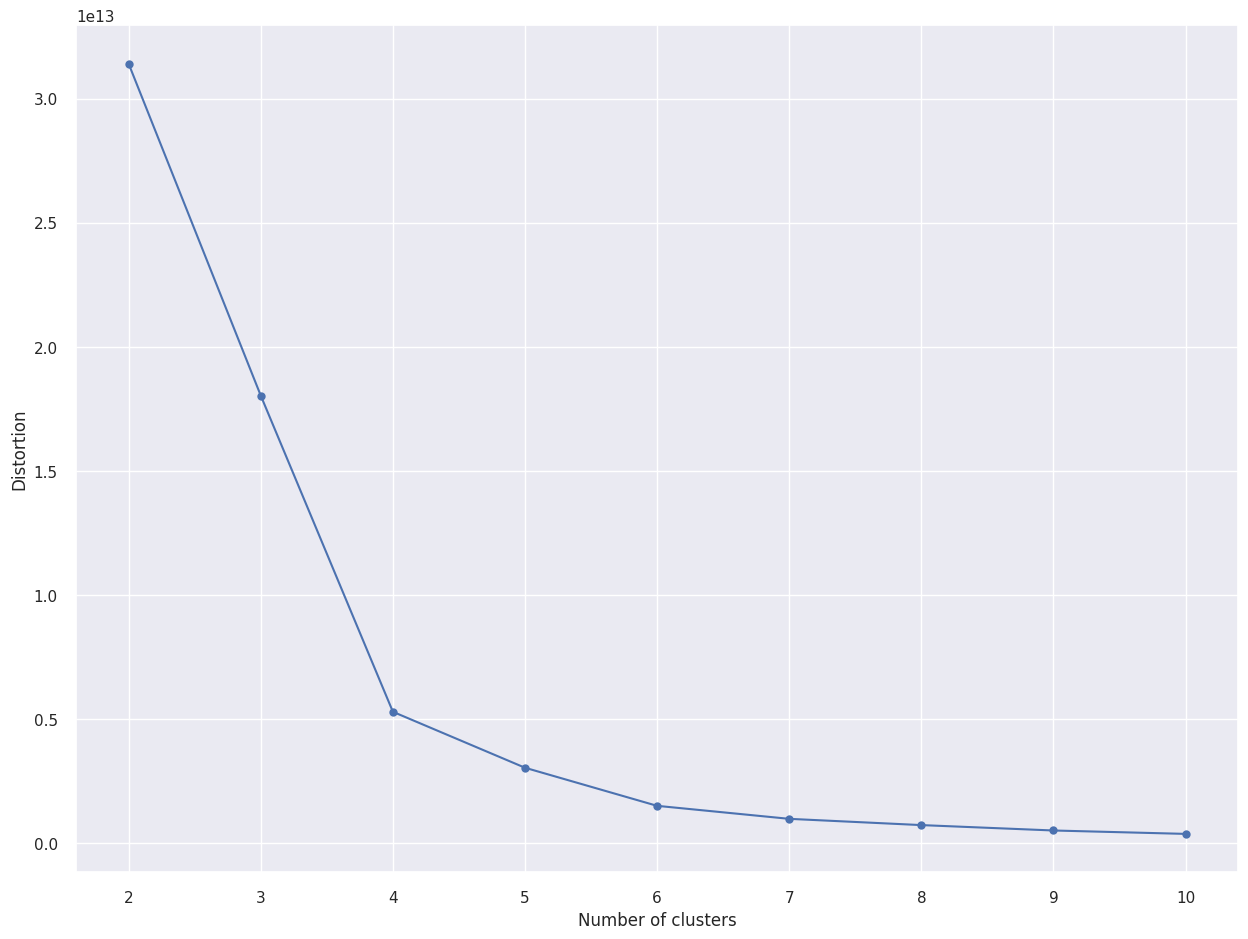

In [96]:
# calculate distortion for a range of number of cluster
distortions = []
db_indexes = {}
for i in range(2, 11):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=7, verbose= 0
    )
    km.fit(X)
    distortions.append(km.inertia_)
    
    labels = km.labels_
    db_indexes[i] = davies_bouldin_score(X, labels)

# plot
plt.plot(range(2, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

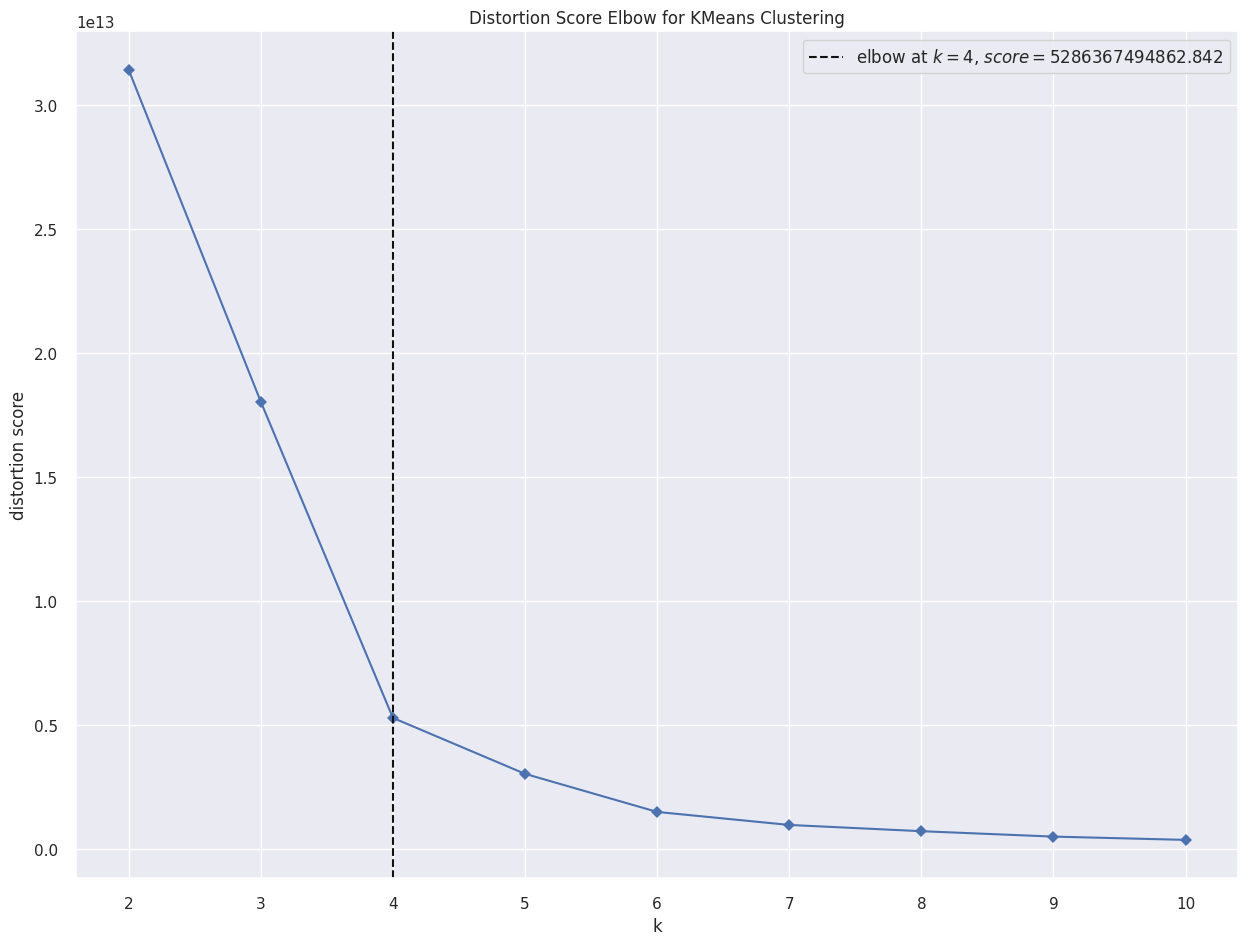

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [97]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11), timings=False)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [98]:
db_indexes

{2: 0.305078373064148,
 3: 0.446469859757693,
 4: 0.2593039145042362,
 5: 0.31219102560956924,
 6: 0.3781221075303152,
 7: 0.38247941189120777,
 8: 0.2849125946657777,
 9: 0.2146681126760646,
 10: 0.24534424843007235}

In [99]:
kmeans = KMeans(
    n_clusters=visualizer.elbow_value_, 
    random_state=7).fit(X)

In [100]:
# pickle.dump(kmeans, open('uci_non_timeseries_kmeans2023.pkl', 'wb'))

In [101]:
clustering_profiles['Cluster'] = kmeans.predict(X)

In [102]:
cluster_profile = clustering_profiles.groupby('Cluster').mean()

#### Calculate each user's distance from each cluster center

In [103]:
sqr_cluster_distance = kmeans.transform(X)**2

In [104]:
sqr_cluster_distance.shape

(368, 4)

In [105]:
sqr_cluster_distance_df = pd.DataFrame(sqr_cluster_distance).add_prefix('centroid_distance_from_')

In [106]:
clustering_profiles['Cluster'] = kmeans.predict(X)

In [107]:
clustering_profiles.shape

(368, 13)

In [108]:
clustering_profiles = pd.merge(clustering_profiles.reset_index(), sqr_cluster_distance_df, left_index=True, right_index=True, how='inner')

In [109]:
clustering_profiles.index = clustering_profiles['houseID']

In [110]:
clustering_profiles = clustering_profiles.drop('houseID', 1)

/tmp/ipykernel_2391835/1695393503.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  clustering_profiles = clustering_profiles.drop('houseID', 1)


In [111]:
cluster_profile = clustering_profiles.groupby('Cluster').mean()

In [112]:
cluster_profile

,Weekend vs weekday difference score,mean_over_max,min_over_mean,var,mean,max,min,Relative average consumption 1,Relative average consumption 2,Relative average consumption 3,Relative average consumption 4,Mean relative standard deviation,centroid_distance_from_0,centroid_distance_from_1,centroid_distance_from_2,centroid_distance_from_3
Cluster,,,,,,,,,,,,,,,,
0,0.219671,0.350859,0.001972,3.015957e+04,230.220774,577.390108,0.533632,0.759033,0.837110,1.152955,1.214121,0.643326,7.039232e+09,1.151881e+13,1.496025e+12,5.321871e+13
1,0.404147,0.324899,0.000000,3.423048e+06,3025.594510,8986.842888,0.000000,0.738572,0.698894,1.160806,1.296268,1.327382,1.184854e+13,3.367640e+11,5.057236e+12,1.556032e+13
2,0.184804,0.379572,0.000000,1.250386e+06,2488.058150,5878.991050,0.000000,0.712931,0.698265,1.184382,1.283391,0.533776,1.576538e+12,4.808024e+12,8.755263e+10,3.698590e+13
3,0.066151,0.296013,0.000000,7.324786e+06,2939.947889,9931.818182,0.000000,0.481002,0.437171,1.354944,1.530166,0.759994,5.321167e+13,1.522356e+13,3.689835e+13,0.000000e+00


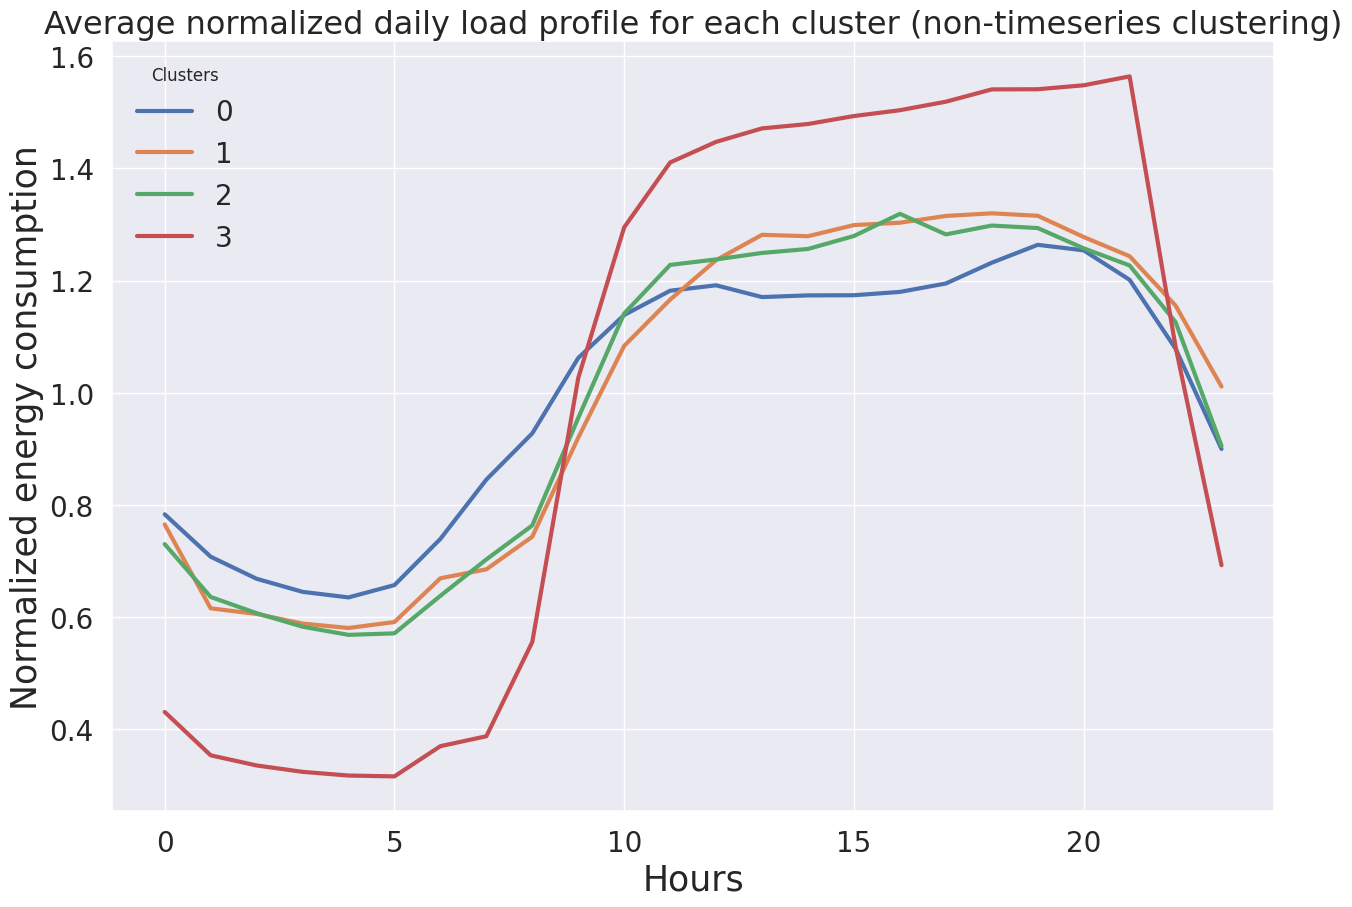

In [113]:
sns.set()

ax = load_profiles.merge(clustering_profiles['Cluster'], left_index=True, right_index=True, how='inner').groupby('Cluster').mean().T.plot(
    figsize=(15,10), linewidth=3, fontsize=20
)

ax.set_title("Average normalized daily load profile for each cluster (non-timeseries clustering)", fontsize=23)
ax.set_xlabel("Hours", fontsize=25)
ax.set_ylabel("Normalized energy consumption", fontsize=25)
ax.legend(loc='upper left', fontsize=20, title="Clusters")
plt.rcParams['legend.title_fontsize'] = 'x-large'
# plt.show()

In [114]:
clustering_profiles.groupby('Cluster').count()

,Weekend vs weekday difference score,mean_over_max,min_over_mean,var,mean,max,min,Relative average consumption 1,Relative average consumption 2,Relative average consumption 3,Relative average consumption 4,Mean relative standard deviation,centroid_distance_from_0,centroid_distance_from_1,centroid_distance_from_2,centroid_distance_from_3
Cluster,,,,,,,,,,,,,,,,
0,352,352,352,352,352,352,352,352,352,352,352,352,352,352,352,352
1,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
2,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [115]:
clustering_profiles.groupby('Cluster').mean()

,Weekend vs weekday difference score,mean_over_max,min_over_mean,var,mean,max,min,Relative average consumption 1,Relative average consumption 2,Relative average consumption 3,Relative average consumption 4,Mean relative standard deviation,centroid_distance_from_0,centroid_distance_from_1,centroid_distance_from_2,centroid_distance_from_3
Cluster,,,,,,,,,,,,,,,,
0,0.219671,0.350859,0.001972,3.015957e+04,230.220774,577.390108,0.533632,0.759033,0.837110,1.152955,1.214121,0.643326,7.039232e+09,1.151881e+13,1.496025e+12,5.321871e+13
1,0.404147,0.324899,0.000000,3.423048e+06,3025.594510,8986.842888,0.000000,0.738572,0.698894,1.160806,1.296268,1.327382,1.184854e+13,3.367640e+11,5.057236e+12,1.556032e+13
2,0.184804,0.379572,0.000000,1.250386e+06,2488.058150,5878.991050,0.000000,0.712931,0.698265,1.184382,1.283391,0.533776,1.576538e+12,4.808024e+12,8.755263e+10,3.698590e+13
3,0.066151,0.296013,0.000000,7.324786e+06,2939.947889,9931.818182,0.000000,0.481002,0.437171,1.354944,1.530166,0.759994,5.321167e+13,1.522356e+13,3.689835e+13,0.000000e+00


In [116]:
clustering_profiles['centroid_distance_from_3'].sort_values()

houseID
MT_364    0.000000e+00
MT_339    8.016428e+12
MT_228    1.254164e+13
MT_208    1.633498e+13
MT_363    1.693661e+13
              ...     
MT_023    5.365217e+13
MT_019    5.365235e+13
MT_347    5.365243e+13
MT_160    5.365246e+13
MT_133    5.365253e+13
Name: centroid_distance_from_3, Length: 368, dtype: float64

In [117]:
# clustering_profiles.to_csv('clustering_profiles_non-timeseries2023.csv')

### Consumption prediction

In [18]:
# clustering_profiles_timeseries = pd.read_csv('clustering_profiles_timeseries2023.csv')

In [19]:
clustering_profiles_timeseries = clustering_profiles_timeseries.rename(columns={'centroid_distance_from_0': 'ts_centroid_distance_from_0', 'centroid_distance_from_1': 'ts_centroid_distance_from_1',
                                                   'centroid_distance_from_2': 'ts_centroid_distance_from_2', 'centroid_distance_from_3': 'ts_centroid_distance_from_3', 
                                                    'centroid_distance_from_4': 'ts_centroid_distance_from_4', 'centroid_distance_from_5': 'ts_centroid_distance_from_5', 'centroid_distance_from_6': 'ts_centroid_distance_from_6',
                                               'centroid_distance_from_7': 'ts_centroid_distance_from_7', 'centroid_distance_from_8': 'ts_centroid_distance_from_8','centroid_distance_from_9': 'ts_centroid_distance_from_9'})

In [20]:
clustering_profiles_non_timeseries = pd.read_csv('clustering_profiles_non-timeseries2023.csv')

In [21]:
clustering_profiles_non_timeseries = clustering_profiles_non_timeseries.rename(columns={'centroid_distance_from_0': 'non_ts_centroid_distance_from_0', 'centroid_distance_from_1': 'non_ts_centroid_distance_from_1',
                                                   'centroid_distance_from_2': 'non_ts_centroid_distance_from_2', 'centroid_distance_from_3': 'non_ts_centroid_distance_from_3', 
                                                    'centroid_distance_from_4': 'non_ts_centroid_distance_from_4'})

In [22]:
len(kwh_hourly_dataset_stacked['houseID'].unique())

370

In [23]:
kwh_hourly_dataset_stacked['Year'].unique()

array([2011, 2012, 2013, 2014, 2015])

In [24]:
kwh_hourly_dataset_stacked.groupby('Year')['Energy(kWh)'].count()

Year
2011    3223896
2012    3226873
2013    3210306
2014    3210021
2015        370
Name: Energy(kWh), dtype: int64

In [25]:
# Keep data only for one year
kwh_hourly_dataset_stacked = kwh_hourly_dataset_stacked.loc[kwh_hourly_dataset_stacked['Year'] == 2014]

In [26]:
clustering_profiles = pd.read_csv('clustering_profiles2023.csv')

In [27]:
dataset_with_clustering_profiles_and_metadata = kwh_hourly_dataset_stacked[['houseID', 'Energy(kWh)', 'Month', 'Hour', 'DayOfYear', 'Weekday']].merge(clustering_profiles, on='houseID', how='inner')

In [28]:
dataset_with_clustering_profiles_and_metadata = dataset_with_clustering_profiles_and_metadata.merge(clustering_profiles_timeseries[['houseID', 'ts_centroid_distance_from_0', 
                                                                                                                                    'ts_centroid_distance_from_1', 'ts_centroid_distance_from_2', 
                                                                                                                                    'ts_centroid_distance_from_3', 'ts_centroid_distance_from_4', 
                                                                                                                                    'ts_centroid_distance_from_5', 'ts_centroid_distance_from_6', 
                                                                                                                                    'ts_centroid_distance_from_7', 'ts_centroid_distance_from_8',
                                                                                                                                    'ts_centroid_distance_from_9']], on='houseID', how='inner')

In [29]:
dataset_with_clustering_profiles_and_metadata = dataset_with_clustering_profiles_and_metadata.merge(clustering_profiles_non_timeseries[['houseID', 'non_ts_centroid_distance_from_0', 
                                                                                                                                    'non_ts_centroid_distance_from_1', 'non_ts_centroid_distance_from_2', 
                                                                                                                                    'non_ts_centroid_distance_from_3'
                                                                                                                                    ]], on='houseID', how='inner')

In [30]:
dataset_with_clustering_profiles_and_metadata = dataset_with_clustering_profiles_and_metadata.set_index('houseID')

In [31]:
dataset_with_clustering_profiles_and_metadata.head(4)

,Energy(kWh),Month,Hour,DayOfYear,Weekday,Weekend vs weekday difference score,0,1,2,3,...,ts_centroid_distance_from_4,ts_centroid_distance_from_5,ts_centroid_distance_from_6,ts_centroid_distance_from_7,ts_centroid_distance_from_8,ts_centroid_distance_from_9,non_ts_centroid_distance_from_0,non_ts_centroid_distance_from_1,non_ts_centroid_distance_from_2,non_ts_centroid_distance_from_3
houseID,,,,,,,,,,,,,,,,,,,,,
MT_001,2.538071,1,0,1,3,0.451673,0.90727,0.94158,0.92047,0.930751,...,0.84479,27.920678,0.56409,0.159856,1.869697,2.80258,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13
MT_001,2.855330,1,1,1,3,0.451673,0.90727,0.94158,0.92047,0.930751,...,0.84479,27.920678,0.56409,0.159856,1.869697,2.80258,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13
MT_001,2.855330,1,2,1,3,0.451673,0.90727,0.94158,0.92047,0.930751,...,0.84479,27.920678,0.56409,0.159856,1.869697,2.80258,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13
MT_001,2.855330,1,3,1,3,0.451673,0.90727,0.94158,0.92047,0.930751,...,0.84479,27.920678,0.56409,0.159856,1.869697,2.80258,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13


In [32]:
# dataset_with_clustering_profiles_and_metadata.to_csv('2014_dataset_with_clustering_profiles_and_metadata2023.csv')

In [2]:
# dataset_with_clustering_profiles_and_metadata = pd.read_csv('2014_dataset_with_clustering_profiles_and_metadata2023.csv')

In [34]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [35]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

In [36]:
np.random.seed(7)
tf.random.set_seed(7)

In [37]:
dataset_with_clustering_profiles_and_metadata.columns

Index(['houseID', 'Energy(kWh)', 'Month', 'Hour', 'DayOfYear', 'Weekday',
       'Weekend vs weekday difference score', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', 'mean_over_max', 'min_over_mean',
       'var', 'mean', 'max', 'min', 'Relative average consumption 1',
       'Relative average consumption 2', 'Relative average consumption 3',
       'Relative average consumption 4', 'Mean relative standard deviation',
       'ts_centroid_distance_from_0', 'ts_centroid_distance_from_1',
       'ts_centroid_distance_from_2', 'ts_centroid_distance_from_3',
       'ts_centroid_distance_from_4', 'ts_centroid_distance_from_5',
       'ts_centroid_distance_from_6', 'ts_centroid_distance_from_7',
       'ts_centroid_distance_from_8', 'ts_centroid_distance_from_9',
       'non_ts_centroid_distance_from_0', 'non_ts_centroid_distance_from_1',
       'non_ts_centroid_distance_from_2', 'non_ts_cent

In [38]:
len(dataset_with_clustering_profiles_and_metadata['houseID'].unique())

368

In [39]:
house_data_count = pd.DataFrame(dataset_with_clustering_profiles_and_metadata.groupby(dataset_with_clustering_profiles_and_metadata['houseID'])['Energy(kWh)'].count())

In [40]:
house_data_count

,Energy(kWh)
houseID,
MT_001,8760
MT_002,8760
MT_003,8760
MT_004,8760
MT_005,8760
...,...
MT_366,8760
MT_367,8760
MT_368,8760


In [41]:
# dataset_with_clustering_profiles_and_metadata = dataset_with_clustering_profiles_and_metadata.loc[dataset_with_clustering_profiles_and_metadata['houseID'].isin(house_data_count.loc[house_data_count['Energy(kWh)'] > 8000].index)]

In [32]:
dataset_with_clustering_profiles_and_metadata.head(8761)

,houseID,Energy(kWh),Month,Hour,DayOfYear,Weekday,Weekend vs weekday difference score,0,1,2,...,ts_centroid_distance_from_4,ts_centroid_distance_from_5,ts_centroid_distance_from_6,ts_centroid_distance_from_7,ts_centroid_distance_from_8,ts_centroid_distance_from_9,non_ts_centroid_distance_from_0,non_ts_centroid_distance_from_1,non_ts_centroid_distance_from_2,non_ts_centroid_distance_from_3
0,MT_001,2.538071,1,0,1,3,0.451673,0.90727,0.941580,0.92047,...,0.84479,27.920678,0.564090,0.159856,1.869697,2.802580,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13
1,MT_001,2.855330,1,1,1,3,0.451673,0.90727,0.941580,0.92047,...,0.84479,27.920678,0.564090,0.159856,1.869697,2.802580,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13
2,MT_001,2.855330,1,2,1,3,0.451673,0.90727,0.941580,0.92047,...,0.84479,27.920678,0.564090,0.159856,1.869697,2.802580,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13
3,MT_001,2.855330,1,3,1,3,0.451673,0.90727,0.941580,0.92047,...,0.84479,27.920678,0.564090,0.159856,1.869697,2.802580,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13
4,MT_001,2.538071,1,4,1,3,0.451673,0.90727,0.941580,0.92047,...,0.84479,27.920678,0.564090,0.159856,1.869697,2.802580,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,MT_001,2.220812,12,20,365,3,0.451673,0.90727,0.941580,0.92047,...,0.84479,27.920678,0.564090,0.159856,1.869697,2.802580,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13
8757,MT_001,2.538071,12,21,365,3,0.451673,0.90727,0.941580,0.92047,...,0.84479,27.920678,0.564090,0.159856,1.869697,2.802580,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13
8758,MT_001,1.903553,12,22,365,3,0.451673,0.90727,0.941580,0.92047,...,0.84479,27.920678,0.564090,0.159856,1.869697,2.802580,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13
8759,MT_001,2.220812,12,23,365,3,0.451673,0.90727,0.941580,0.92047,...,0.84479,27.920678,0.564090,0.159856,1.869697,2.802580,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13


In [34]:
dataset_with_clustering_profiles_and_metadata.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,Energy(kWh),Month,Hour,DayOfYear,Weekday,Weekend vs weekday difference score,0,1,2,3,...,ts_centroid_distance_from_4,ts_centroid_distance_from_5,ts_centroid_distance_from_6,ts_centroid_distance_from_7,ts_centroid_distance_from_8,ts_centroid_distance_from_9,non_ts_centroid_distance_from_0,non_ts_centroid_distance_from_1,non_ts_centroid_distance_from_2,non_ts_centroid_distance_from_3
count,3209196.00000,3209196.00000,3209196.00000,3209196.00000,3209196.00000,3209196.00000,3209196.00000,3209196.00000,3209196.00000,3209196.00000,...,3209196.00000,3209196.00000,3209196.00000,3209196.00000,3209196.00000,3209196.00000,3209196.00000,3209196.00000,3209196.00000,3209196.00000
mean,356.37504,6.52579,11.49461,182.99273,2.99985,0.21551,0.77933,0.70136,0.66248,0.63925,...,0.73536,26.18819,0.68017,1.39215,1.68178,1.73785,361924916594.17548,11225041280162.21094,1617624932821.69116,52179003556630.51562
std,776.48953,3.44821,6.92423,105.37751,1.99734,0.42052,0.28171,0.23334,0.21470,0.20949,...,1.79153,4.50689,1.85562,2.26907,1.74817,2.15741,3180739385470.88770,1729923026102.81885,1952859053098.41016,5912974714576.69141
min,0.00000,1.00000,0.00000,1.00000,0.00000,0.00695,0.12024,0.12068,0.12261,0.12201,...,0.01561,0.00000,0.02486,0.01909,0.12654,0.06178,989255.11874,19589502383.05469,4609130002.80542,0.00000
25%,49.79253,4.00000,5.00000,92.00000,1.00000,0.03633,0.60046,0.56410,0.54794,0.53484,...,0.07082,23.97081,0.11870,0.47175,0.90434,0.95740,611900683.65720,11609205968923.66406,1526880219029.79248,53420560538497.25000
50%,117.50408,7.00000,11.00000,183.00000,3.00000,0.06974,0.72333,0.65194,0.62595,0.60996,...,0.22598,26.02350,0.25535,0.81104,1.54378,1.25823,824448600.57719,11696020984569.84961,1556460068692.07031,53606799886059.82031
75%,293.95762,10.00000,17.00000,274.00000,5.00000,0.19730,0.93195,0.84239,0.75656,0.72352,...,0.87762,28.28603,0.57668,1.40302,2.02167,1.71716,894614185.16305,11711537385915.77930,1561520177485.79248,53639986356102.53125
max,10163.86555,12.00000,23.00000,365.00000,6.00000,3.58923,3.21315,1.94152,1.79382,1.70464,...,25.63998,41.02767,27.18537,33.04194,28.92130,21.58709,53211669605567.61719,15223557182829.53125,36898351534237.10156,53652528597382.77344


In [43]:
# Save the indexes where the houseID changes
houseID_change_indexes = pd.DataFrame(dataset_with_clustering_profiles_and_metadata['houseID']).ne(pd.DataFrame(dataset_with_clustering_profiles_and_metadata['houseID']).shift()).apply(lambda x: x.index[x].tolist())

In [44]:
houseID_change_indexes

,houseID
0,0
1,8760
2,17520
3,26280
4,35040
...,...
363,3173806
364,3182566
365,3191326
366,3200086


In [45]:
# delete first element which is 0
houseID_change_indexes = houseID_change_indexes.iloc[1: , :]

In [46]:
houseID_change_indexes

,houseID
1,8760
2,17520
3,26280
4,35040
5,43800
...,...
363,3173806
364,3182566
365,3191326
366,3200086


In [47]:
X = dataset_with_clustering_profiles_and_metadata[['Month', 'Hour', 'DayOfYear', 'Weekday',
       'Weekend vs weekday difference score', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', 'mean_over_max', 'min_over_mean',
       'var', 'mean', 'max', 'min', 'Relative average consumption 1',
       'Relative average consumption 2', 'Relative average consumption 3',
       'Relative average consumption 4', 'Mean relative standard deviation',
#        'Seasonal score', 
       'ts_centroid_distance_from_0',
       'ts_centroid_distance_from_1', 'ts_centroid_distance_from_2',
       'ts_centroid_distance_from_3', 'ts_centroid_distance_from_4',
       'ts_centroid_distance_from_5', 'ts_centroid_distance_from_6', 'ts_centroid_distance_from_7',
       'ts_centroid_distance_from_8', 'ts_centroid_distance_from_9',
       'non_ts_centroid_distance_from_0', 'non_ts_centroid_distance_from_1',
       'non_ts_centroid_distance_from_2', 'non_ts_centroid_distance_from_3',
       ]].values
y = dataset_with_clustering_profiles_and_metadata['Energy(kWh)'].values

In [48]:
scalerX = MinMaxScaler()
np_scaledX = scalerX.fit_transform(X)
normalizedX = pd.DataFrame(data=np_scaledX, columns=['Month', 'Hour', 'DayOfYear', 'Weekday',
       'Weekend vs weekday difference score', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', 'mean_over_max', 'min_over_mean',
       'var', 'mean', 'max', 'min', 'Relative average consumption 1',
       'Relative average consumption 2', 'Relative average consumption 3',
       'Relative average consumption 4', 'Mean relative standard deviation',
#        'Seasonal score', 
       'ts_centroid_distance_from_0',
       'ts_centroid_distance_from_1', 'ts_centroid_distance_from_2',
       'ts_centroid_distance_from_3', 'ts_centroid_distance_from_4',
       'ts_centroid_distance_from_5', 'ts_centroid_distance_from_6', 'ts_centroid_distance_from_7',
       'ts_centroid_distance_from_8', 'ts_centroid_distance_from_9',
       'non_ts_centroid_distance_from_0', 'non_ts_centroid_distance_from_1',
       'non_ts_centroid_distance_from_2', 'non_ts_centroid_distance_from_3',
       ]) 

scalerY = MinMaxScaler()
y = y.reshape(-1, 1)
np_scaledY = scalerY.fit_transform(y)
normalizedY = pd.DataFrame(data=np_scaledY, columns=['Energy(kWh)'])

In [49]:
joblib.dump(scalerX, 'uci_scalerX_no_boxcox2023.pkl')


['uci_scalerX_no_boxcox2023.pkl']

In [50]:
joblib.dump(scalerY, 'uci_scalerY_no_boxcox2023.pkl') 

['uci_scalerY_no_boxcox2023.pkl']

In [51]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
#     for i in range(len(sequences)):
    i = 0
    while i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # check if we are beyond of this house's time-series 
        if (end_ix in houseID_change_indexes):
            # jump n_steps ahead
            i = i + n_steps
            # delete the respective row from the MLP input and output vectors
            normalizedX.drop(list(range(end_ix, end_ix + n_steps)), inplace=True)
#             normalizedY.drop(list(range(end_ix, end_ix + n_steps)))
            
            continue
        else:
            # gather input and output parts of the pattern
            seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
            X.append(seq_x)
            y.append(seq_y)
        i = i + 1
    return array(X), array(y)

In [52]:
from numpy import array, newaxis
from numpy import hstack

# horizontally stack column
dataset = hstack((normalizedY.shift(1), normalizedY))
# choose a number of time steps
n_steps = 24*1
# convert into input/output
X_lstm, y_lstm = split_sequences(dataset, n_steps)
print(X_lstm.shape, y_lstm.shape)

(3209173, 24, 1) (3209173,)


In [53]:
normalizedY.head(n_steps)

,Energy(kWh)
0,0.000250
1,0.000281
2,0.000281
3,0.000281
4,0.000250
5,0.000250
6,0.000312
7,0.000281
8,0.000125
9,0.000031


In [54]:
X_lstm[0]

array([[           nan],
       [2.49715136e-04],
       [2.80929528e-04],
       [2.80929528e-04],
       [2.80929528e-04],
       [2.49715136e-04],
       [2.49715136e-04],
       [3.12143920e-04],
       [2.80929528e-04],
       [1.24857568e-04],
       [3.12143920e-05],
       [6.24287840e-05],
       [3.12143920e-05],
       [6.24287840e-05],
       [3.12143920e-05],
       [3.12143920e-05],
       [6.24287840e-05],
       [2.18500744e-04],
       [2.18500744e-04],
       [2.80929528e-04],
       [2.80929528e-04],
       [2.49715136e-04],
       [2.49715136e-04],
       [3.12143920e-04]])

In [55]:
X_lstm[0][0] = X_lstm[0][1]

In [56]:
y_lstm[0]

0.0002497151358849043

In [57]:
normalizedY.shift(-n_steps+1).values[0]

array([0.00024972])

In [58]:
normalizedX.shift(-n_steps+1).values[0]

array([0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 5.00000000e-01,
       1.24146495e-01, 2.54463203e-01, 4.50833781e-01, 4.77416556e-01,
       5.11012334e-01, 5.21508917e-01, 4.34961990e-01, 3.25738806e-01,
       5.57066626e-01, 6.12527519e-01, 8.43218643e-01, 4.83833611e-01,
       4.14469955e-01, 3.64395406e-01, 1.86902621e-01, 1.67161235e-01,
       1.50240304e-01, 1.13326539e-01, 3.57023842e-01, 3.80005934e-01,
       4.80802343e-01, 4.68400270e-01, 5.29020855e-01, 4.51972783e-01,
       5.29027780e-01, 1.25335032e-01, 0.00000000e+00, 3.82367083e-06,
       3.94499773e-04, 1.36570917e-03, 0.00000000e+00, 5.86873706e-01,
       5.51435959e-01, 4.06087749e-01, 3.64136671e-01, 2.82171221e-01,
       6.15471982e-02, 2.47402502e-02, 2.04270619e-01, 1.78144982e-01,
       3.23589876e-02, 6.80532885e-01, 1.98535692e-02, 4.26255072e-03,
       6.05372461e-02, 1.27329047e-01, 1.70448950e-05, 7.69373942e-01,
       4.22514678e-02, 9.99992349e-01])

In [59]:
# shift the MLP input data by n_steps-1 hours upwards so that they are aligned with the RNN data
normalizedX = normalizedX.shift(-n_steps+1).dropna()

In [60]:
normalizedX.shape

(3209173, 54)

In [61]:
X_lstm.shape

(3209173, 24, 1)

In [62]:
y_lstm.shape

(3209173,)

In [63]:
normalizedX = normalizedX.values[..., newaxis]

In [64]:
normalizedX.shape

(3209173, 54, 1)

In [65]:
np.isnan(X_lstm).any()

False

In [66]:
X_concatenated = np.concatenate((X_lstm, normalizedX), axis=1)

In [67]:
X_concatenated = X_concatenated.reshape(X_concatenated.shape[0],X_concatenated.shape[1])

In [68]:
X_concatenated.shape

(3209173, 78)

In [69]:
np.isnan(X_concatenated).any()

False

In [70]:
np.isfinite(X_concatenated).all()

True

In [71]:
X_train_concatenated, X_test_concatenated, y_train_concatenated, y_test_concatenated = train_test_split(X_concatenated, y_lstm, test_size = 0.2, shuffle = True)

In [72]:
X_train_concatenated.shape

(2567338, 78)

In [73]:
X_test_concatenated.shape

(641835, 78)

In [74]:
y_train_concatenated.shape

(2567338,)

In [75]:
y_test_concatenated.shape

(641835,)

In [76]:
X_train_concatenated.shape

(2567338, 78)

In [77]:
def crop(dimension, start, end):
    # Crops (or slices) a Tensor on a given dimension from start to end
    # example : to crop tensor x[:, :, 5:10]
    # call slice(2, 5, 10) as you want to crop on the second dimension 
    def func(x):
        if dimension == 0:
            return x[start: end]
        if dimension == 1:
            if end == -1:
                return x[:, start:]
            else:
                return x[:, start: end]
        if dimension == 2:
            return x[:, :, start: end]
        if dimension == 3:
            return x[:, :, :, start: end]
        if dimension == 4:
            return x[:, :, :, :, start: end]
    return Lambda(func)

In [214]:
np.random.seed(7)
tf.random.set_seed(7)

In [217]:
clean_up(model)

In [218]:
# split the input feature vector to the RNN's and MLP's inputs  
X_train_lstm = X_train_concatenated[:,:n_steps]
X_train_mlp = X_train_concatenated[:,n_steps:]

features = X_train_concatenated.shape[1]
inputs =  Input(shape=(features,))

# RNN
features = 1
sliced = crop(1,0,n_steps)(inputs)
rnn_inputs = Reshape((n_steps,features))(sliced)

gru = GRU(64, kernel_initializer='glorot_uniform', dropout=0.2, return_sequences=False)(rnn_inputs)
# gru = GRU(64, kernel_initializer='glorot_uniform', dropout=0, return_sequences=False)(gru)
# gru = GRU(64, kernel_initializer='glorot_uniform', dropout=0, return_sequences=False)(gru)
# gru = BatchNormalization()(gru)

# MLP
sliced = crop(1,n_steps,-1)(inputs)
concatenated = Concatenate()([gru, sliced])

concatenated = Dropout(0.5)(concatenated)

mlp = Dense(500, kernel_initializer='glorot_uniform', activation='elu')(concatenated)
# mlp = BatchNormalization()(mlp)
mlp = Dropout(0.2)(mlp)
mlp = Dense(100, kernel_initializer='glorot_uniform', activation='elu')(mlp)
# mlp = BatchNormalization()(mlp)
mlp = Dropout(0.2)(mlp)
mlp = Dense(50, kernel_initializer='glorot_uniform', activation='elu')(mlp)
# mlp = BatchNormalization()(mlp)
mlp = Dropout(0.2)(mlp)
mlp = Dense(10, kernel_initializer='glorot_uniform', activation='elu')(mlp)
# mlp = BatchNormalization()(mlp)
mlp = Dropout(0.2)(mlp)
outputs = Dense(1, kernel_initializer='uniform', activation='selu')(mlp)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 78)]         0           []                               
                                                                                                  
 lambda (Lambda)                (None, 24)           0           ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 24, 1)        0           ['lambda[0][0]']                 
                                                                                                  
 gru (GRU)                      (None, 64)           12864       ['reshape[0][0]']                
                                                                                              

In [219]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30, min_delta=0.0001, restore_best_weights=True)
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(), metrics=['mae', 'acc'])
history = model.fit(X_train_concatenated, y_train_concatenated, epochs=100, batch_size=512, verbose=1, validation_split=0.1, callbacks=[es])

Epoch 1/100


2023-04-21 09:52:12.234298: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2023-04-21 09:52:12.360739: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4513/4513 [==============================] - 48s 10ms/step - loss: 7.7292e-04 - mae: 0.0136 - acc: 0.0161 - val_loss: 2.6397e-04 - val_mae: 0.0055 - val_acc: 0.0160
Epoch 2/100
4513/4513 [==============================] - 46s 10ms/step - loss: 4.4381e-04 - mae: 0.0103 - acc: 0.0161 - val_loss: 5.5178e-04 - val_mae: 0.0095 - val_acc: 0.0160
Epoch 3/100
4513/4513 [==============================] - 47s 10ms/step - loss: 3.8895e-04 - mae: 0.0095 - acc: 0.0161 - val_loss: 4.0998e-04 - val_mae: 0.0101 - val_acc: 0.0160
Epoch 4/100
4513/4513 [==============================] - 46s 10ms/step - loss: 3.6861e-04 - mae: 0.0091 - acc: 0.0161 - val_loss: 2.1762e-04 - val_mae: 0.0068 - val_acc: 0.0160
Epoch 5/100
4513/4513 [==============================] - 47s 10ms/step - loss: 3.5679e-04 - mae: 0.0090 - acc: 0.0161 - val_loss: 4.1176e-04 - val_mae: 0.0078 - val_acc: 0.0160
Epoch 6/100
4513/4513 [==============================] - 47s 10ms/step - loss: 3.4485e-04 - mae: 0.0088 - acc: 0.0161 - val_los

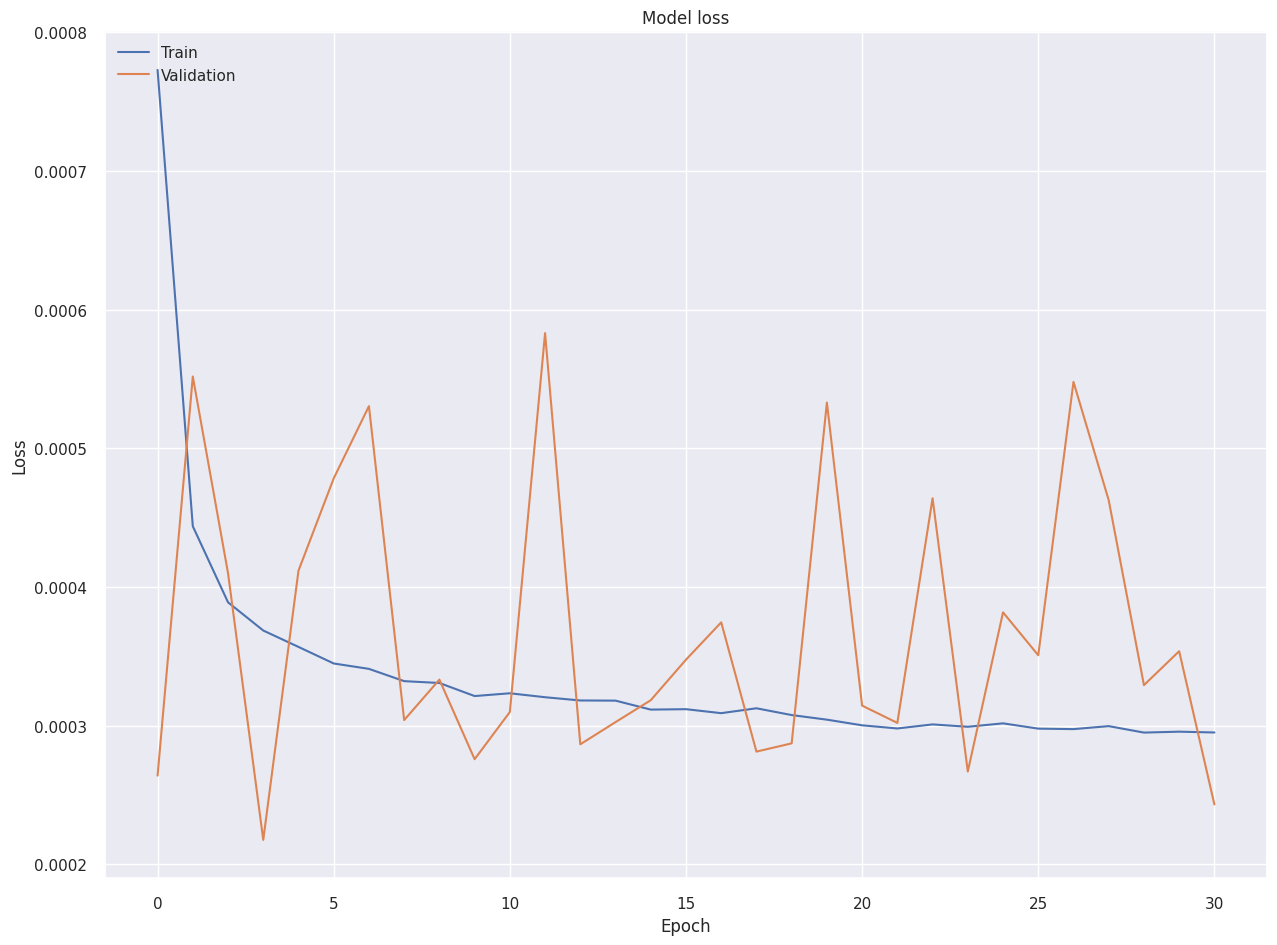

In [220]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [222]:
model.save('selu_dropout_24h_rnn_encoder_mlp_no_boxcox2023.h5')

In [223]:
y_pred = model.predict(X_test_concatenated)

20058/20058 [==============================] - 64s 3ms/step


In [224]:
acc_nn = r2_score(y_test_concatenated, y_pred)
print("R^2= "+ str(acc_nn))
print("Mean Absolute Percentage Error = "+str(mean_absolute_percentage_error(y_test_concatenated, y_pred)))


evaluation = model.evaluate(x = X_test_concatenated, y = y_test_concatenated, verbose=1) # Returns MSE, MAE, ACC
mse = evaluation[0]
mae = evaluation[1]
acc = evaluation[2]
print('MSE='+str(mse))
print('MAE='+str(mae))
print('ACC='+str(acc))

R^2= 0.9546308882159038
Mean Absolute Percentage Error = 69.00105300942346
20058/20058 [==============================] - 90s 4ms/step - loss: 2.6497e-04 - mae: 0.0055 - acc: 0.0160
MSE=0.0002649696252774447
MAE=0.005496140103787184
ACC=0.01602904126048088


#### Evaluation after inverse tranformations

In [225]:
# maxlog = 0.17500766608716162

In [226]:
y_test_concatenated = scalerY.inverse_transform(y_test_concatenated.reshape(-1,1))

In [227]:
y_pred = scalerY.inverse_transform(y_pred)

In [228]:
acc_nn = r2_score(y_test_concatenated, y_pred)
print("R^2= "+ str(acc_nn))
print("Mean Absolute Percentage Error = "+str(mean_absolute_percentage_error(y_test_concatenated, y_pred)))

R^2= 0.9546308881465893
Mean Absolute Percentage Error = 69.00105338805132


In [229]:
print("Mean Squared Error = "+str(mean_squared_error(y_test_concatenated, y_pred)))

Mean Squared Error = 27372.491434501266


In [230]:
print("Root Mean Squared Error = "+str(sqrt(mean_squared_error(y_test_concatenated, y_pred))))

Root Mean Squared Error = 165.44634004565125


In [231]:
# RMSE is a good estimator for the standard deviation σ of the distribution of our errors!

In [232]:
print("Mean Absolute Error = "+str(mean_absolute_error(y_test_concatenated, y_pred)))

Mean Absolute Error = 55.86196806992382


In [233]:
print("Normalized Root Mean Squared Error (NRMSE) = "+str(sqrt(mean_squared_error(y_test_concatenated, y_pred)) / np.mean(y_test_concatenated) ))

Normalized Root Mean Squared Error (NRMSE) = 0.4648748201705691


In [234]:
np.mean(y_test_concatenated) 

355.8943889130125

In [235]:
print("Normalized deviation (ND) = "+str(np.sum(np.abs(y_test_concatenated-y_pred)) / np.sum(np.abs(y_test_concatenated))))

Normalized deviation (ND) = 0.15696220510961068


In [2]:
dataset_with_clustering_profiles_and_metadata = pd.read_csv('2014_dataset_with_clustering_profiles_and_metadata2023.csv')

#### Skewness

In [3]:
dataset_with_clustering_profiles_and_metadata['Energy(kWh)'] = dataset_with_clustering_profiles_and_metadata['Energy(kWh)'].replace(to_replace=0, value=0.0001)

In [4]:
stats.skew(dataset_with_clustering_profiles_and_metadata['Energy(kWh)'])

5.564597574739244

In [5]:
stats.skew(np.log(dataset_with_clustering_profiles_and_metadata['Energy(kWh)'])) 

-3.5572485482615033

In [6]:
stats.skew(np.sqrt(dataset_with_clustering_profiles_and_metadata['Energy(kWh)']))

2.449026618540765

#### Box Cox tranformation to reduce skewness

In [7]:
box_cox, maxlog = stats.boxcox(dataset_with_clustering_profiles_and_metadata['Energy(kWh)'])
pd.Series(box_cox).skew()

0.224569826072454

In [8]:
box_cox

array([ 1.01063746,  1.15043179,  1.15043179, ..., 21.74844153,
       21.33787011, 20.91326739])

In [9]:
maxlog # maxlogfloat, optional. If the lmbda parameter is None, the second returned argument is the lambda that maximizes the log-likelihood function.

0.17298947003355672

In [10]:
box_cox_dataset = boxcox(dataset_with_clustering_profiles_and_metadata['Energy(kWh)'], maxlog)

In [11]:
inv_boxcox(box_cox_dataset, maxlog).head(5)

0    2.538071
1    2.855330
2    2.855330
3    2.855330
4    2.538071
Name: Energy(kWh), dtype: float64

In [12]:
pickle.dump(boxcox, open('uci_boxcox.pkl', 'wb'))

In [13]:
dataset_with_clustering_profiles_and_metadata['Energy(kWh)'].head(5)

0    2.538071
1    2.855330
2    2.855330
3    2.855330
4    2.538071
Name: Energy(kWh), dtype: float64

In [14]:
dataset_with_clustering_profiles_and_metadata['Energy(kWh)'] = box_cox_dataset

In [15]:
dataset_with_clustering_profiles_and_metadata = dataset_with_clustering_profiles_and_metadata.sort_values(['houseID', 'DayOfYear', 'Month', 'Weekday', 'Hour'], ascending=[True, True, True, True, True])

In [16]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [17]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

In [18]:
np.random.seed(7)
tf.random.set_seed(7)

In [19]:
dataset_with_clustering_profiles_and_metadata.columns

Index(['houseID', 'Energy(kWh)', 'Month', 'Hour', 'DayOfYear', 'Weekday',
       'Weekend vs weekday difference score', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', 'mean_over_max', 'min_over_mean',
       'var', 'mean', 'max', 'min', 'Relative average consumption 1',
       'Relative average consumption 2', 'Relative average consumption 3',
       'Relative average consumption 4', 'Mean relative standard deviation',
       'ts_centroid_distance_from_0', 'ts_centroid_distance_from_1',
       'ts_centroid_distance_from_2', 'ts_centroid_distance_from_3',
       'ts_centroid_distance_from_4', 'ts_centroid_distance_from_5',
       'ts_centroid_distance_from_6', 'ts_centroid_distance_from_7',
       'ts_centroid_distance_from_8', 'ts_centroid_distance_from_9',
       'non_ts_centroid_distance_from_0', 'non_ts_centroid_distance_from_1',
       'non_ts_centroid_distance_from_2', 'non_ts_cent

In [20]:
len(dataset_with_clustering_profiles_and_metadata['houseID'].unique())

368

In [21]:
house_data_count = pd.DataFrame(dataset_with_clustering_profiles_and_metadata.groupby(dataset_with_clustering_profiles_and_metadata['houseID'])['Energy(kWh)'].count())

In [22]:
house_data_count

,Energy(kWh)
houseID,
MT_001,8760
MT_002,8760
MT_003,8760
MT_004,8760
MT_005,8760
...,...
MT_366,8760
MT_367,8760
MT_368,8760


In [23]:
dataset_with_clustering_profiles_and_metadata = dataset_with_clustering_profiles_and_metadata.loc[dataset_with_clustering_profiles_and_metadata['houseID'].isin(house_data_count.loc[house_data_count['Energy(kWh)'] > 8000].index)]

In [24]:
dataset_with_clustering_profiles_and_metadata.head(8761)

,houseID,Energy(kWh),Month,Hour,DayOfYear,Weekday,Weekend vs weekday difference score,0,1,2,...,ts_centroid_distance_from_4,ts_centroid_distance_from_5,ts_centroid_distance_from_6,ts_centroid_distance_from_7,ts_centroid_distance_from_8,ts_centroid_distance_from_9,non_ts_centroid_distance_from_0,non_ts_centroid_distance_from_1,non_ts_centroid_distance_from_2,non_ts_centroid_distance_from_3
0,MT_001,1.010637,1,0,1,3,0.451673,0.90727,0.941580,0.92047,...,0.84479,27.920678,0.564090,0.159856,1.869697,2.802580,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13
1,MT_001,1.150432,1,1,1,3,0.451673,0.90727,0.941580,0.92047,...,0.84479,27.920678,0.564090,0.159856,1.869697,2.802580,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13
2,MT_001,1.150432,1,2,1,3,0.451673,0.90727,0.941580,0.92047,...,0.84479,27.920678,0.564090,0.159856,1.869697,2.802580,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13
3,MT_001,1.150432,1,3,1,3,0.451673,0.90727,0.941580,0.92047,...,0.84479,27.920678,0.564090,0.159856,1.869697,2.802580,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13
4,MT_001,1.010637,1,4,1,3,0.451673,0.90727,0.941580,0.92047,...,0.84479,27.920678,0.564090,0.159856,1.869697,2.802580,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,MT_001,0.855559,12,20,365,3,0.451673,0.90727,0.941580,0.92047,...,0.84479,27.920678,0.564090,0.159856,1.869697,2.802580,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13
8757,MT_001,1.010637,12,21,365,3,0.451673,0.90727,0.941580,0.92047,...,0.84479,27.920678,0.564090,0.159856,1.869697,2.802580,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13
8758,MT_001,0.680932,12,22,365,3,0.451673,0.90727,0.941580,0.92047,...,0.84479,27.920678,0.564090,0.159856,1.869697,2.802580,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13
8759,MT_001,0.855559,12,23,365,3,0.451673,0.90727,0.941580,0.92047,...,0.84479,27.920678,0.564090,0.159856,1.869697,2.802580,9.079766e+08,1.171713e+13,1.563424e+12,5.365212e+13


In [25]:
dataset_with_clustering_profiles_and_metadata.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,Energy(kWh),Month,Hour,DayOfYear,Weekday,Weekend vs weekday difference score,0,1,2,3,...,ts_centroid_distance_from_4,ts_centroid_distance_from_5,ts_centroid_distance_from_6,ts_centroid_distance_from_7,ts_centroid_distance_from_8,ts_centroid_distance_from_9,non_ts_centroid_distance_from_0,non_ts_centroid_distance_from_1,non_ts_centroid_distance_from_2,non_ts_centroid_distance_from_3
count,3206090.00000,3206090.00000,3206090.00000,3206090.00000,3206090.00000,3206090.00000,3206090.00000,3206090.00000,3206090.00000,3206090.00000,...,3206090.00000,3206090.00000,3206090.00000,3206090.00000,3206090.00000,3206090.00000,3206090.00000,3206090.00000,3206090.00000,3206090.00000
mean,7.80836,6.52602,11.49991,182.99957,3.00001,0.21489,0.77911,0.70106,0.66214,0.63888,...,0.73495,26.18072,0.67999,1.39332,1.68241,1.73541,359452230426.39679,11232935658024.58984,1618880739483.90674,52198819598440.30469
std,3.77464,3.44789,6.92223,105.36711,1.99727,0.42000,0.28176,0.23326,0.21451,0.20926,...,1.79234,4.50267,1.85651,2.26986,1.74890,2.15701,3180976225156.16211,1711833678321.37744,1953299962477.82178,5880405939034.49805
min,-4.60574,1.00000,0.00000,1.00000,0.00000,0.00695,0.12024,0.12068,0.12261,0.12201,...,0.01561,0.00000,0.02486,0.01909,0.12654,0.06178,989255.11874,19589502383.05469,4609130002.80542,0.00000
25%,5.58281,4.00000,5.00000,92.00000,1.00000,0.03633,0.60046,0.56410,0.54794,0.53484,...,0.07082,23.97081,0.11870,0.47175,0.90434,0.95740,611900683.65720,11609205968923.66406,1526880219029.79248,53420560538497.25000
50%,7.40115,7.00000,11.00000,183.00000,3.00000,0.06974,0.72281,0.65156,0.62577,0.60949,...,0.22598,26.02088,0.25535,0.81619,1.56004,1.25716,823485450.25437,11696455170128.23047,1556460068692.07031,53606952890703.74219
75%,9.66153,10.00000,17.00000,274.00000,5.00000,0.19730,0.93195,0.84239,0.75656,0.72352,...,0.87762,28.28603,0.57668,1.40302,2.02167,1.71716,894614185.16305,11711537385915.77930,1561520177485.79248,53639986356102.53125
max,22.73995,12.00000,23.00000,365.00000,6.00000,3.58923,3.21315,1.94152,1.79382,1.70464,...,25.63998,41.02767,27.18537,33.04194,28.92130,21.58709,53211669605567.61719,15223557182829.53125,36898351534237.10156,53652528597382.77344


In [26]:
# Save the indexes where the houseID changes
houseID_change_indexes = pd.DataFrame(dataset_with_clustering_profiles_and_metadata['houseID']).ne(pd.DataFrame(dataset_with_clustering_profiles_and_metadata['houseID']).shift()).apply(lambda x: x.index[x].tolist())

In [27]:
houseID_change_indexes

,houseID
0,0
1,8760
2,17520
3,26280
4,35040
...,...
361,3165046
362,3173806
363,3182566
364,3191326


In [28]:
# delete first element which is 0
houseID_change_indexes = houseID_change_indexes.iloc[1: , :]

In [29]:
houseID_change_indexes

,houseID
1,8760
2,17520
3,26280
4,35040
5,43800
...,...
361,3165046
362,3173806
363,3182566
364,3191326


In [30]:
X = dataset_with_clustering_profiles_and_metadata[['Month', 'Hour', 'DayOfYear', 'Weekday',
       'Weekend vs weekday difference score', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', 'mean_over_max', 'min_over_mean',
       'var', 'mean', 'max', 'min', 'Relative average consumption 1',
       'Relative average consumption 2', 'Relative average consumption 3',
       'Relative average consumption 4', 'Mean relative standard deviation',
#        'Seasonal score', 
       'ts_centroid_distance_from_0',
       'ts_centroid_distance_from_1', 'ts_centroid_distance_from_2',
       'ts_centroid_distance_from_3', 'ts_centroid_distance_from_4',
       'ts_centroid_distance_from_5', 'ts_centroid_distance_from_6', 'ts_centroid_distance_from_7',
       'ts_centroid_distance_from_8', 'ts_centroid_distance_from_9',
       'non_ts_centroid_distance_from_0', 'non_ts_centroid_distance_from_1',
       'non_ts_centroid_distance_from_2', 'non_ts_centroid_distance_from_3',
       ]].values
y = dataset_with_clustering_profiles_and_metadata['Energy(kWh)'].values

In [31]:
scalerX = MinMaxScaler()
np_scaledX = scalerX.fit_transform(X)
normalizedX = pd.DataFrame(data=np_scaledX, columns=['Month', 'Hour', 'DayOfYear', 'Weekday',
       'Weekend vs weekday difference score', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', 'mean_over_max', 'min_over_mean',
       'var', 'mean', 'max', 'min', 'Relative average consumption 1',
       'Relative average consumption 2', 'Relative average consumption 3',
       'Relative average consumption 4', 'Mean relative standard deviation',
#        'Seasonal score', 
       'ts_centroid_distance_from_0',
       'ts_centroid_distance_from_1', 'ts_centroid_distance_from_2',
       'ts_centroid_distance_from_3', 'ts_centroid_distance_from_4',
       'ts_centroid_distance_from_5', 'ts_centroid_distance_from_6', 'ts_centroid_distance_from_7',
       'ts_centroid_distance_from_8', 'ts_centroid_distance_from_9',
       'non_ts_centroid_distance_from_0', 'non_ts_centroid_distance_from_1',
       'non_ts_centroid_distance_from_2', 'non_ts_centroid_distance_from_3',
       ]) 

scalerY = MinMaxScaler()
y = y.reshape(-1, 1)
np_scaledY = scalerY.fit_transform(y)
normalizedY = pd.DataFrame(data=np_scaledY, columns=['Energy(kWh)'])

In [32]:
normalizedY.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,Energy(kWh)
count,3206090.00000
mean,0.45397
std,0.13803
min,0.00000
25%,0.37258
50%,0.43908
75%,0.52174
max,1.00000


In [33]:
joblib.dump(scalerX, 'uci_scalerX_boxcox2023.pkl')


['uci_scalerX_boxcox2023.pkl']

In [34]:
joblib.dump(scalerY, 'uci_scalerY_boxcox2023.pkl') 

['uci_scalerY_boxcox2023.pkl']

In [35]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
#     for i in range(len(sequences)):
    i = 0
    while i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # check if we are beyond of this house's time-series 
        if (end_ix in houseID_change_indexes):
            # jump n_steps ahead
            i = i + n_steps
            # delete the respective row from the MLP input and output vectors
            normalizedX.drop(list(range(end_ix, end_ix + n_steps)), inplace=True)
#             normalizedY.drop(list(range(end_ix, end_ix + n_steps)))
            
            continue
        else:
            # gather input and output parts of the pattern
            seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
            X.append(seq_x)
            y.append(seq_y)
        i = i + 1
    return array(X), array(y)

In [36]:
from numpy import array, newaxis
from numpy import hstack

# horizontally stack column
dataset = hstack((normalizedY.shift(1), normalizedY))
# choose a number of time steps
n_steps = 24*7
# convert into input/output
X_lstm, y_lstm = split_sequences(dataset, n_steps)
print(X_lstm.shape, y_lstm.shape)

(3205923, 168, 1) (3205923,)


In [37]:
normalizedY.head(n_steps)

,Energy(kWh)
0,0.205384
1,0.210497
2,0.210497
3,0.210497
4,0.205384
...,...
163,0.193327
164,0.199713
165,0.193327
166,0.199713


In [38]:
X_lstm[0]

array([[       nan],
       [0.20538442],
       [0.21049654],
       [0.21049654],
       [0.21049654],
       [0.20538442],
       [0.20538442],
       [0.21515858],
       [0.21049654],
       [0.17732142],
       [0.13035021],
       [0.15242945],
       [0.13035021],
       [0.15242945],
       [0.13035021],
       [0.13035021],
       [0.15242945],
       [0.19971338],
       [0.19971338],
       [0.21049654],
       [0.21049654],
       [0.20538442],
       [0.20538442],
       [0.21515858],
       [0.20538442],
       [0.20538442],
       [0.21049654],
       [0.21049654],
       [0.20538442],
       [0.21049654],
       [0.21049654],
       [0.20538442],
       [0.21049654],
       [0.19971338],
       [0.20538442],
       [0.18599113],
       [0.20538442],
       [0.18599113],
       [0.21049654],
       [0.17732142],
       [0.21049654],
       [0.19332748],
       [0.19332748],
       [0.19971338],
       [0.19971338],
       [0.19971338],
       [0.20538442],
       [0.199

In [39]:
X_lstm[0][0] = X_lstm[0][1]

In [40]:
y_lstm[0]

0.1997133754078015

In [41]:
normalizedY.shift(-n_steps+1).values[0]

array([0.19971338])

In [42]:
normalizedX.shift(-n_steps+1).values[0]

array([0.00000000e+00, 1.00000000e+00, 1.64835165e-02, 3.33333333e-01,
       1.24146495e-01, 2.54463203e-01, 4.50833781e-01, 4.77416556e-01,
       5.11012334e-01, 5.21508917e-01, 4.34961990e-01, 3.25738806e-01,
       5.57066626e-01, 6.12527519e-01, 8.43218643e-01, 4.83833611e-01,
       4.14469955e-01, 3.64395406e-01, 1.86902621e-01, 1.67161235e-01,
       1.50240304e-01, 1.13326539e-01, 3.57023842e-01, 3.80005934e-01,
       4.80802343e-01, 4.68400270e-01, 5.29020855e-01, 4.51972783e-01,
       5.29027780e-01, 1.54202184e-01, 0.00000000e+00, 3.82367083e-06,
       4.92051070e-04, 1.36570917e-03, 0.00000000e+00, 5.86873706e-01,
       5.51435959e-01, 4.06087749e-01, 3.64136671e-01, 3.89277467e-01,
       6.15471982e-02, 2.47402502e-02, 2.04270619e-01, 1.78144982e-01,
       3.23589876e-02, 6.80532885e-01, 1.98535692e-02, 4.26255072e-03,
       6.05372461e-02, 1.27329047e-01, 1.70448950e-05, 7.69373942e-01,
       4.22514678e-02, 9.99992349e-01])

In [43]:
# shift the MLP input data by n_steps-1 hours upwards so that they are aligned with the RNN data
normalizedX = normalizedX.shift(-n_steps+1).dropna()

In [44]:
normalizedX.shape

(3205923, 54)

In [45]:
X_lstm.shape

(3205923, 168, 1)

In [46]:
y_lstm.shape

(3205923,)

In [47]:
normalizedX = normalizedX.values[..., newaxis]

In [48]:
normalizedX.shape

(3205923, 54, 1)

In [49]:
np.isnan(X_lstm).any()

False

In [50]:
X_concatenated = np.concatenate((X_lstm, normalizedX), axis=1)

In [51]:
X_concatenated = X_concatenated.reshape(X_concatenated.shape[0],X_concatenated.shape[1])

In [52]:
X_concatenated.shape

(3205923, 222)

In [53]:
np.isnan(X_concatenated).any()

False

In [54]:
np.isfinite(X_concatenated).all()

True

In [82]:
X_train_concatenated, X_test_concatenated, y_train_concatenated, y_test_concatenated = train_test_split(X_concatenated, y_lstm, test_size = 0.2, shuffle = True)

In [56]:
X_train_concatenated.shape

(2564738, 222)

In [57]:
X_test_concatenated.shape

(641185, 222)

In [58]:
y_train_concatenated.shape

(2564738,)

In [59]:
y_test_concatenated.shape

(641185,)

In [60]:
X_train_concatenated.shape

(2564738, 222)

In [61]:
def crop(dimension, start, end):
    # Crops (or slices) a Tensor on a given dimension from start to end
    # example : to crop tensor x[:, :, 5:10]
    # call slice(2, 5, 10) as you want to crop on the second dimension 
    def func(x):
        if dimension == 0:
            return x[start: end]
        if dimension == 1:
            if end == -1:
                return x[:, start:]
            else:
                return x[:, start: end]
        if dimension == 2:
            return x[:, :, start: end]
        if dimension == 3:
            return x[:, :, :, start: end]
        if dimension == 4:
            return x[:, :, :, :, start: end]
    return Lambda(func)

In [62]:
np.random.seed(7)
tf.random.set_seed(7)

In [63]:
clean_up(model)

NameError: name 'model' is not defined

In [64]:
# split the input feature vector to the RNN's and MLP's inputs  
X_train_lstm = X_train_concatenated[:,:n_steps]
X_train_mlp = X_train_concatenated[:,n_steps:]

features = X_train_concatenated.shape[1]
inputs =  Input(shape=(features,))

# RNN
features = 1
sliced = crop(1,0,n_steps)(inputs)
rnn_inputs = Reshape((n_steps,features))(sliced)

gru = GRU(64, kernel_initializer='glorot_uniform', dropout=0, return_sequences=False)(rnn_inputs)
# gru = GRU(64, kernel_initializer='glorot_uniform', dropout=0, return_sequences=False)(gru)
# gru = GRU(64, kernel_initializer='glorot_uniform', dropout=0, return_sequences=False)(gru)
# gru = BatchNormalization()(gru)

# MLP
sliced = crop(1,n_steps,-1)(inputs)
concatenated = Concatenate()([gru, sliced])

concatenated = Dropout(0.5)(concatenated)

mlp = Dense(500, kernel_initializer='glorot_uniform', activation='elu')(concatenated)
# mlp = BatchNormalization()(mlp)
mlp = Dropout(0.5)(mlp)
mlp = Dense(100, kernel_initializer='glorot_uniform', activation='elu')(mlp)
# mlp = BatchNormalization()(mlp)
mlp = Dropout(0.5)(mlp)
mlp = Dense(50, kernel_initializer='glorot_uniform', activation='elu')(mlp)
# mlp = BatchNormalization()(mlp)
mlp = Dropout(0.5)(mlp)
mlp = Dense(10, kernel_initializer='glorot_uniform', activation='elu')(mlp)
# mlp = BatchNormalization()(mlp)
mlp = Dropout(0.5)(mlp)
outputs = Dense(1, kernel_initializer='uniform', activation='linear')(mlp)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

2023-07-07 12:57:26.586992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-07 12:57:26.782995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-07 12:57:26.783448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-07 12:57:26.784418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 222)]        0           []                               
                                                                                                  
 lambda (Lambda)                (None, 168)          0           ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 168, 1)       0           ['lambda[0][0]']                 
                                                                                                  
 gru (GRU)                      (None, 64)           12864       ['reshape[0][0]']                
                                                                                              

In [65]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=45, min_delta=0.0001, restore_best_weights=True)
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(), metrics=['mae', 'acc'])
history = model.fit(X_train_concatenated, y_train_concatenated, epochs=100, batch_size=512, verbose=1, validation_split=0.1, callbacks=[es])

Epoch 1/100


2023-07-07 12:57:46.648981: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2023-07-07 12:57:46.843519: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4509/4509 [==============================] - 94s 20ms/step - loss: 0.0059 - mae: 0.0486 - acc: 0.0161 - val_loss: 6.3763e-04 - val_mae: 0.0148 - val_acc: 0.0161
Epoch 2/100
4509/4509 [==============================] - 90s 20ms/step - loss: 0.0028 - mae: 0.0341 - acc: 0.0162 - val_loss: 7.0398e-04 - val_mae: 0.0163 - val_acc: 0.0161
Epoch 3/100
4509/4509 [==============================] - 90s 20ms/step - loss: 0.0027 - mae: 0.0333 - acc: 0.0162 - val_loss: 4.6846e-04 - val_mae: 0.0118 - val_acc: 0.0161
Epoch 4/100
4509/4509 [==============================] - 90s 20ms/step - loss: 0.0026 - mae: 0.0330 - acc: 0.0162 - val_loss: 5.1099e-04 - val_mae: 0.0138 - val_acc: 0.0161
Epoch 5/100
4509/4509 [==============================] - 91s 20ms/step - loss: 0.0026 - mae: 0.0328 - acc: 0.0162 - val_loss: 8.0006e-04 - val_mae: 0.0184 - val_acc: 0.0161
Epoch 6/100
4509/4509 [==============================] - 92s 20ms/step - loss: 0.0026 - mae: 0.0328 - acc: 0.0162 - val_loss: 4.3282e-04 - val_mae:

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

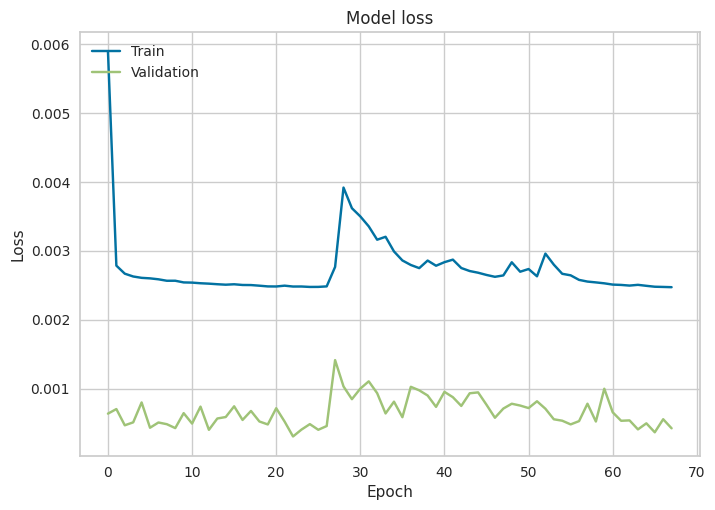

In [66]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [69]:
model.save('linear_dropout_168h_rnn_encoder_mlp_boxcox2023.h5')

In [130]:
# from keras.models import load_model
# model = load_model('selu_dropout_168h_rnn_encoder_mlp_no_boxcox2023.h5')

In [83]:
y_pred = model.predict(X_test_concatenated)

20038/20038 [==============================] - 142s 7ms/step


In [84]:
acc_nn = r2_score(y_test_concatenated, y_pred)
print("R^2= "+ str(acc_nn))
print("Mean Absolute Percentage Error = "+str(mean_absolute_percentage_error(y_test_concatenated, y_pred)))


evaluation = model.evaluate(x = X_test_concatenated, y = y_test_concatenated, verbose=1) # Returns MSE, MAE, ACC
mse = evaluation[0]
mae = evaluation[1]
acc = evaluation[2]
print('MSE='+str(mse))
print('MAE='+str(mae))
print('ACC='+str(acc))

R^2= 0.9844356784425686
Mean Absolute Percentage Error = 2.245796023550879
20038/20038 [==============================] - 154s 8ms/step - loss: 2.9669e-04 - mae: 0.0098 - acc: 0.0158
MSE=0.00029668997740373015
MAE=0.009773442521691322
ACC=0.01583162508904934


#### Evaluation after inverse tranformations

In [85]:
maxlog = 0.17298947003355672

In [86]:
y_test_concatenated = inv_boxcox(scalerY.inverse_transform(y_test_concatenated.reshape(-1,1)), maxlog)
# y_test_concatenated = scalerY.inverse_transform(y_test_concatenated.reshape(-1,1))

In [87]:
y_pred = inv_boxcox(scalerY.inverse_transform(y_pred), maxlog)
# y_pred = scalerY.inverse_transform(y_pred)

In [88]:
acc_nn = r2_score(y_test_concatenated, y_pred)
print("R^2= "+ str(acc_nn))
print("Mean Absolute Percentage Error = "+str(mean_absolute_percentage_error(y_test_concatenated, y_pred)))

R^2= 0.9581792347893001
Mean Absolute Percentage Error = 24472.36902262215


In [89]:
print("Mean Squared Error = "+str(mean_squared_error(y_test_concatenated, y_pred)))

Mean Squared Error = 22809.397227278976


In [90]:
print("Root Mean Squared Error = "+str(sqrt(mean_squared_error(y_test_concatenated, y_pred))))

Root Mean Squared Error = 151.02780282874733


In [91]:
# RMSE is a good estimator for the standard deviation σ of the distribution of our errors!

In [92]:
print("Mean Absolute Error = "+str(mean_absolute_error(y_test_concatenated, y_pred)))

Mean Absolute Error = 38.81113306671381


In [93]:
print("Normalized Root Mean Squared Error (NRMSE) = "+str(sqrt(mean_squared_error(y_test_concatenated, y_pred)) / np.mean(y_test_concatenated) ))

Normalized Root Mean Squared Error (NRMSE) = 0.4315334269050715


In [94]:
np.mean(y_test_concatenated) 

349.97938378008973

In [95]:
print("Normalized deviation (ND) = "+str(np.sum(np.abs(y_test_concatenated-y_pred)) / np.sum(np.abs(y_test_concatenated))))

Normalized deviation (ND) = 0.1108954837496967
